# 이 건물들은 언제, 왜 전기를 쓰는 걸까?

## 건물 유형별 전력사용량 줄이는 방법 알아보기

분석가: **끙정**

In [1]:
# 패키지 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

from IPython.display import Image

from sklearn.cluster import KMeans

from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

# 0. INTRO

우리는 다양한 전자기기를 통해 전력을 사용하고 있습니다. 기술이 발전할수록 디지털화는 가속화되고 있으며, 해를 거듭할수록 전력사용량은 기하급수적으로 늘어가고 있습니다.

한국 에너지 공단은 에너지 효율을 높이기 위해 건물 부문에서 많은 사업을 진행하고 있습니다. **건물 에너지 관리 시스템을 구축**하거나, **에너지 효율 등급이 좋은 건물에 대한 인증을 제공**하는 사업들을 진행하며 늘어나는 전력사용량을 효율화하고 있죠. 이렇듯 급증하는 전력 사용량을 줄이는 것은 정말 중요한 과제입니다.

본 대회에서 제공되는 데이터는 기상 데이터와 건물 정보입니다. 전력 소모에 큰 영향을 끼치는 요인은 아무래도 냉난방 시스템이기 때문에 기상의 영향은 아주 클 것입니다. 또한 본 데이터에서 제공되는 컬럼 중에 **비전기 냉방 시스템**이나, **태양광 발전 시스템**은 전력 소모량을 줄일 수 있는 하나의 방법일 수 있습니다.

**따라서 본 분석은 전력 소모에 영향을 끼치는 주요 요인을 찾고, 전력 소모량을 줄일 수 있는 방법을 찾는 것을 목적으로 합니다.**

다만, 수 많은 건물을 전부 분석하기에는 너무 많은 자원과 비용이 들 것입니다.<br>
고로 **비슷한 유형의 건물들을 군집화** 시키고, 군집별로 어떠한 특징을 가지고 있는지,<br>
또 어떻게 전력사용량을 줄일 수 있을지 살펴보도록 하겠습니다-!

용의주도한 전략가, 자유로운 영혼의 연예인, 사교적인 외교관, 재기발랄한 활동가와 함께 분석을 떠나보겠습니다.

In [2]:
cl_url = 'https://user-images.githubusercontent.com/52409420/122428817-36d36100-cfcd-11eb-971d-125aff553d72.png'
Image(url=cl_url, width=800)

In [3]:
PATH = r'C:\Users\Wyatt\wyatt37\data\energy'

컬럼 이름을 코딩하기 쉽게 간단한 영단어로 변환해주겠습니다.

- 전력사용량 -> target
- 기온 -> temp
- 풍속 -> wind
- 습도 -> humid
- 강수량 -> rain
- 일조 -> sunny
- 비전기냉방설비운영 -> cooler
- 태양광보유 -> solar

In [4]:
# 컬럼명 변환을 위한 리스트 할당
train_col = ['num', 'date_time', 'target', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']
test_col = ['num', 'date_time', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']

In [5]:
# 데이터 로드
train = pd.read_csv(PATH + '\\train.csv', encoding='cp949', names=train_col, header=0)
test = pd.read_csv(PATH + '\\test.csv', encoding='cp949', names=test_col, header=0)
sub = pd.read_csv(PATH + '\\sample_submission.csv', encoding='cp949')

# 1. 전처리

## 1.1 시간 변수 추가

In [6]:
def make_time(train):
    """
    시간 관련 변수를 추가하기 위한 함수
    """
    train['date_time'] = pd.to_datetime(train.date_time)
    
    train['month'] = train.date_time.dt.month                    # 월(숫자)
    train['day'] = train.date_time.dt.day                        # 일(숫자)
    train['hour'] = train.date_time.dt.hour                      # 시(숫자)
    train['weekday'] = train.date_time.dt.weekday                # 요일(숫자)
    train['dayofyear'] = train.date_time.dt.dayofyear            # 연 기준 몇일째(숫자)
    
    return train

In [7]:
train = make_time(train)
test = make_time(test)

In [8]:
# 6월 6일은 현충일, 8월 15일은 광복절, 8월 17일은 임시공휴일
# 휴일이 많지 않으니, 주말에 포함시키겠습니다.

train.loc[train.weekday >= 5, 'holiday'] = 1
train.loc[train.weekday < 5, 'holiday'] = 0
train.loc[(train.month == 8) & (train.day == 17), 'holiday'] = 1

test.loc[test.weekday >= 5, 'holiday'] = 1
test.loc[test.weekday < 5, 'holiday'] = 0

## 1.2 결측치 보간

In [9]:
# test에 cooler와 solar를 넣어주겠습니다.
for i in range(1, 61):
    test.loc[test.num == i, 'cooler'] = train.loc[train.num == i, 'cooler'].mean()
    test.loc[test.num == i, 'solar'] = train.loc[train.num == i, 'solar'].mean()

In [10]:
# test set의 빈 값을 채워줍니다.
test[['temp', 'wind', 'humid', 'rain', 'sunny']] = test[['temp', 'wind', 'humid', 'rain', 'sunny']].interpolate(method='values').round(1)

In [11]:
train.head()

num           date_time    target  temp  wind  humid  rain  sunny  cooler  \
0    1 2020-06-01 00:00:00  8179.056  17.6   2.5   92.0   0.8    0.0     0.0   
1    1 2020-06-01 01:00:00  8135.640  17.7   2.9   91.0   0.3    0.0     0.0   
2    1 2020-06-01 02:00:00  8107.128  17.5   3.2   91.0   0.0    0.0     0.0   
3    1 2020-06-01 03:00:00  8048.808  17.1   3.2   91.0   0.0    0.0     0.0   
4    1 2020-06-01 04:00:00  8043.624  17.0   3.3   92.0   0.0    0.0     0.0   

   solar  month  day  hour  weekday  dayofyear  holiday  
0    0.0      6    1     0        0        153      0.0  
1    0.0      6    1     1        0        153      0.0  
2    0.0      6    1     2        0        153      0.0  
3    0.0      6    1     3        0        153      0.0  
4    0.0      6    1     4        0        153      0.0

In [12]:
test.head()

num           date_time  temp  wind  humid  rain  sunny  cooler  solar  \
0    1 2020-08-25 00:00:00  27.8   1.5   74.0   0.0    0.0     0.0    0.0   
1    1 2020-08-25 01:00:00  27.6   1.4   75.3   0.0    0.0     0.0    0.0   
2    1 2020-08-25 02:00:00  27.5   1.2   76.7   0.0    0.0     0.0    0.0   
3    1 2020-08-25 03:00:00  27.3   1.1   78.0   0.0    0.0     0.0    0.0   
4    1 2020-08-25 04:00:00  26.9   1.2   79.7   0.0    0.0     0.0    0.0   

   month  day  hour  weekday  dayofyear  holiday  
0      8   25     0        1        238      0.0  
1      8   25     1        1        238      0.0  
2      8   25     2        1        238      0.0  
3      8   25     3        1        238      0.0  
4      8   25     4        1        238      0.0

# 2. 분석

본격적인 분석에 앞서 시간의 흐름에 따라 데이터가 어떤 흐름을 보이는지 간단히 살펴보겠습니다.

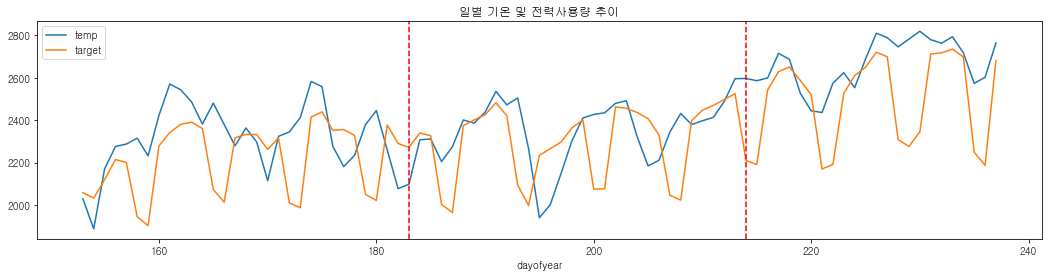

In [13]:
(train.groupby(['dayofyear'])['temp'].mean()*100).plot(figsize=(18, 4))
train.groupby(['dayofyear'])['target'].mean().plot(figsize=(18, 4))
plt.legend(['temp', 'target'])
plt.axvline(x = 183, color = 'r', linestyle = '--',)
plt.axvline(x = 214, color = 'r', linestyle = '--',)
plt.title('일별 기온 및 전력사용량 추이')
plt.show()

일간 평균 기온과 전력 사용량을 6, 7, 8월로 구분한 플롯입니다.<br>
7월 초순이 끝날 무렵 바닥을 쳤다가, 그 이후로 꾸준히 상승하는 경향을 보입니다.<br>
일반적으로 전력 사용량은 기온과 비슷한 흐름으로 흘러갑니다.

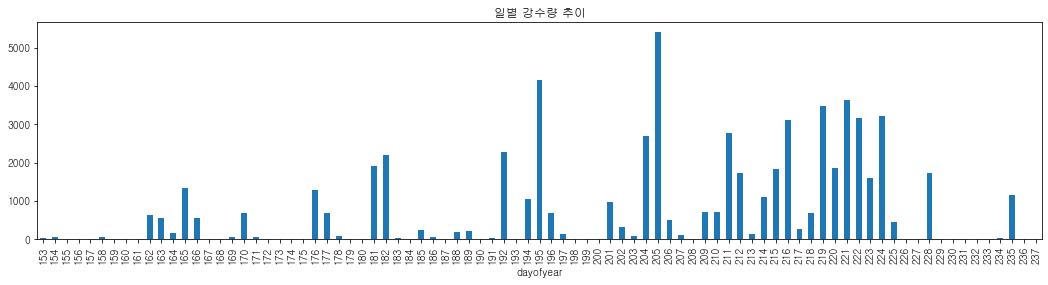

In [14]:
(train.groupby(['dayofyear'])['rain'].sum()).plot(kind='bar', figsize=(18, 4))
plt.title('일별 강수량 추이')
plt.show()

7월 말부터 8월 중순까지는 쉬지 않고 매일 비가 내렸습니다. 장마라고 충분히 표현할 수 있을 것 같습니다.

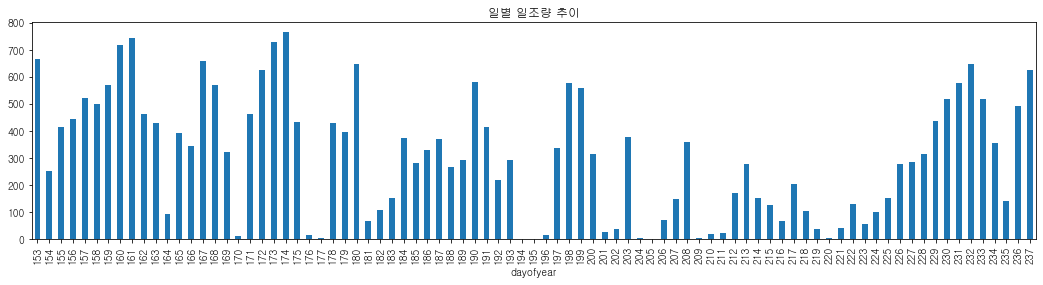

In [15]:
train.groupby(['dayofyear'])['sunny'].sum().plot(kind='bar', figsize=(18, 4))
plt.title('일별 일조량 추이')
plt.show()

일별 일조시간을 바차트로 그려본 것입니다. 장마 시즌에는 일조시간이 줄어들며, 6월과 8월 말에 높은 일조시간을 보이는 것을 알 수 있습니다.

- 6월, 7월보다 8월 말로 갈수록 더욱 기온은 높아집니다.
- 기온이 높아짐에 따라 전력 사용량도 같이 높아지는 경향을 보입니다.
- 7월 말부터 장마의 영향을 받으며 비내리는 날이 많아집니다.
- 8월 말에는 장마가 끝나며, 비가 오는 날이 거의 없습니다.
- 일조 시간은 6월에 가장 높았고, 장마 시즌에 줄어들었으며, 8월에 다시 오르고 있습니다.

## 2.1 건물별 전력 사용 패턴 분석

### 2.1.1 군집화를 통한 유형 분류

먼저 건물의 유형과 용도를 파악하기 위해 비슷한 건물들끼리 묶어보겠습니다. '동준이'님의 코드를 참고하였습니다. 감사합니다.

https://www.dacon.io/competitions/official/235736/codeshare/2743?page=1&dtype=recent

kmeans 외에도 DBSCAN, 계층적군집 등을 사용해보았으나, kmeans가 가장 좋은 군집화를 보였습니다.

In [16]:
train_origin = train.copy()

In [17]:
# 정확한 군집화를 위한 스케일링
for i in range(1, 61):
    mean_ = train.loc[train.num == i].target.mean()
    std_ = train.loc[train.num == i].target.std()
    train.loc[train.num == i, 'target'] = ((train.loc[train.num == i, 'target']) - mean_) / std_

In [18]:
# 요일에 따른 평균 값 산출
weekday_mean = (
    train.groupby(['num', 'weekday'])['target'].mean()
    .reset_index()
    .pivot('num', 'weekday', 'target')
    .reset_index()
)

In [19]:
# 시간에 따른 평균 값 산출
hour_mean = (
    train.groupby(['num', 'hour'])['target'].mean()
    .reset_index()
    .pivot('num', 'hour', 'target')
    .reset_index()
    .drop('num', axis=1)
)

In [20]:
# 요일별, 시간별 평균 전력 사용량 테이블 구축
cl_df = pd.concat([weekday_mean, hour_mean], axis=1)

In [21]:
# 보기 편하게 컬럼 이름 지정
columns = (
    ['num']
    + ['day_mean_' + str(i) for i in range(7)]
    + ['hour_mean_' + str(i) for i in range(24)]
)

cl_df.columns = columns

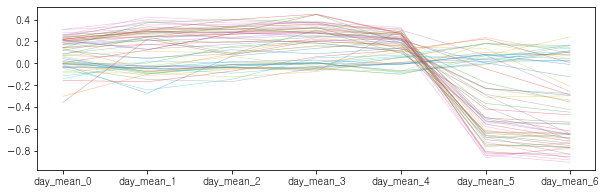

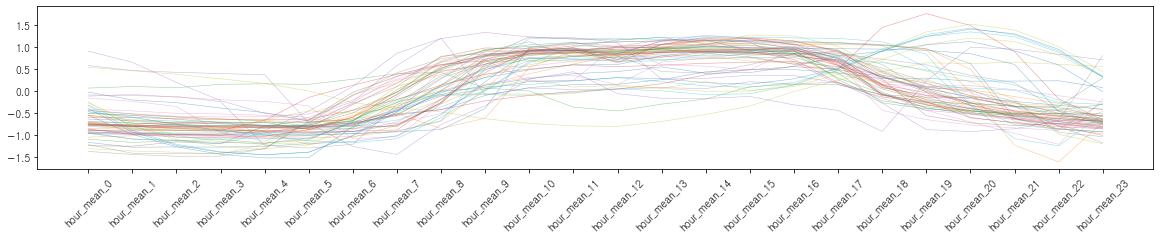

In [22]:
# 시각화를 통한 확인
fig = plt.figure(figsize = (10,3))
for i in range(len(cl_df)):
    plt.plot(cl_df.iloc[i, 1:8], alpha = 0.5, linewidth = 0.5)
    
fig = plt.figure(figsize = (20,3))
for i in range(len(cl_df)):
    plt.plot(cl_df.iloc[i, 8:32], alpha = 0.5, linewidth = 0.5)
    plt.xticks(rotation=45)

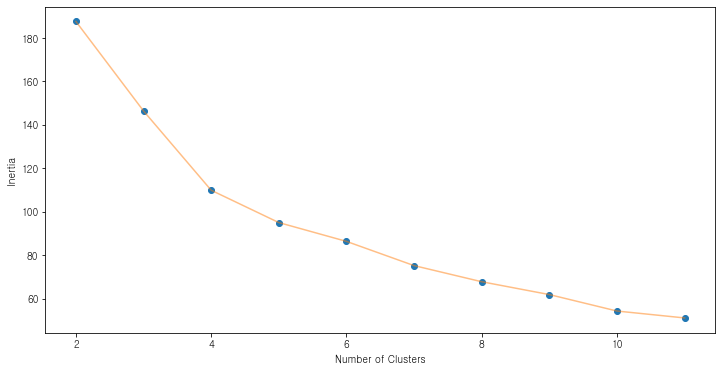

In [23]:
# elbow method를 통해 군집의 개수 결정
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (12, 6))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], cl_df.iloc[:,1:])

엘보우 포인트가 4를 가리키고 있습니다. (사실 여러가지 해봤는데 4가 가장 좋았습니다.)

In [24]:
# 엘보우 포인트를 통해 kmeans 클러스터링
model = KMeans(n_clusters = 4, random_state = 42)
pred = model.fit_predict(cl_df.iloc[:, 1:])

In [25]:
# 값 할당
cl_df['km_cluster'] = pred

In [26]:
# 기존 train set과 merge
train_cl = pd.merge(train, cl_df[['num', 'km_cluster']], how='left', on='num')

In [27]:
test_cl = test.copy()

In [28]:
# test set에도 클러스터 값 할당
for i in range(1, 61):
    test_cl.loc[test_cl.num == i, 'km_cluster'] = (
        train_cl.loc[train_cl.num == i, 'km_cluster'].max()
    )

In [29]:
# 군집별 분석을 위한 4개의 데이터셋 할당
km_0 = list(train_cl.loc[train_cl.km_cluster == 0].num.unique())
km_1 = list(train_cl.loc[train_cl.km_cluster == 1].num.unique())
km_2 = list(train_cl.loc[train_cl.km_cluster == 2].num.unique())
km_3 = list(train_cl.loc[train_cl.km_cluster == 3].num.unique())

### 2.1.2 군집 유형 비교

In [30]:
train_cl.groupby(['km_cluster'])['num'].count().to_frame()/2040

num
km_cluster      
0           33.0
1            5.0
2           15.0
3            7.0

0번 유형이 가장 많은 비중을 차지하며, 다음으로 2번, 3번, 1번 순입니다.

유형별로 건물을 살펴보겠습니다.

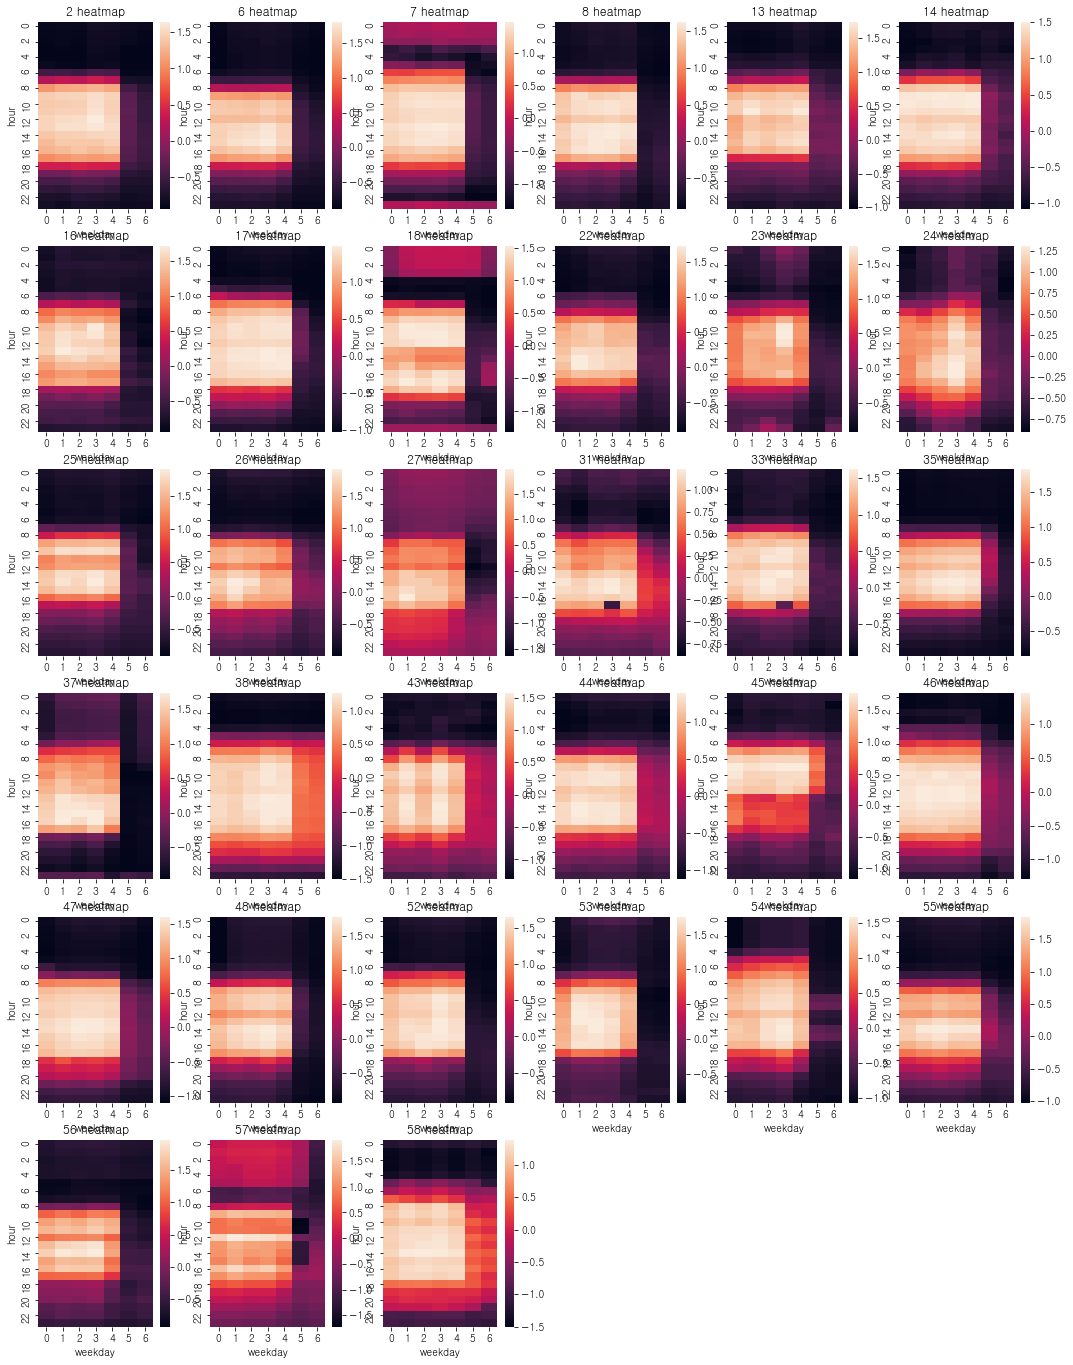

In [31]:
fig = plt.figure(figsize=(18, np.ceil(len(km_0)/6)*4))
for i, n in enumerate(km_0):
    plt.subplot(np.ceil(len(km_0)/6), 6, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

- 건물별로 편차는 존재하지만, 대체로 평일 업무 시간대에 전력사용량이 집중되어 있습니다.
- 그 외의 시간과 요일에는 전력사용량이 급격히 감소하는 것을 알 수 있습니다.

In [32]:
cl_0_url = 'https://user-images.githubusercontent.com/52409420/122412337-6fb90900-cfc0-11eb-9b1a-c188306a14e7.png'
Image(url=cl_0_url, width=250)

- 철저하게 평일 9-6 시간에만 집중적으로 전력을 사용하는 용의주도한 **전략가형 건물**이라고 하겠습니다.

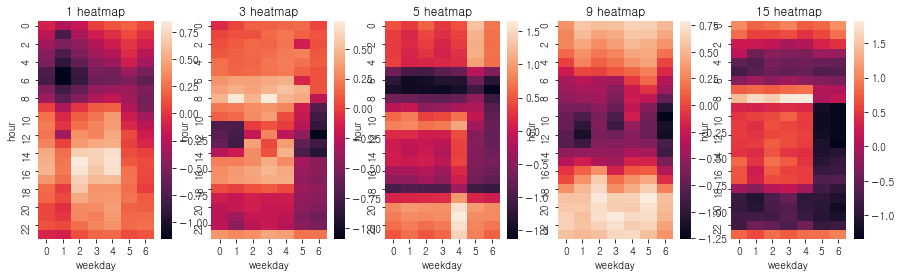

In [33]:
fig = plt.figure(figsize=(15, np.ceil(len(km_1)/5)*4))
for i, n in enumerate(km_1):
    plt.subplot(np.ceil(len(km_1)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

- 정체를 알 수 없는 1번 클러스터입니다. 건물 모두 사용 패턴이 다소 다르며, 예상치 못한 시간에 전력 사용이 없습니다.
- 다른 유형에 끼지 못한 다양한 패턴의 건물들이 모인 것 같습니다.
- 사실 같은 유형으로 묶는 것도 다소 건물들에게 미안하긴 합니다.

In [34]:
cl_1_url = 'https://user-images.githubusercontent.com/52409420/122412417-80697f00-cfc0-11eb-9c71-6bffb406d666.png'
Image(url=cl_1_url, width=250)

- 다양한 패턴의 건물들이 모여 있으며, 각 건물들도 패턴을 파악할 수 없는 자유로운 영혼의 **연예인형 건물**이라고 하겠습니다.

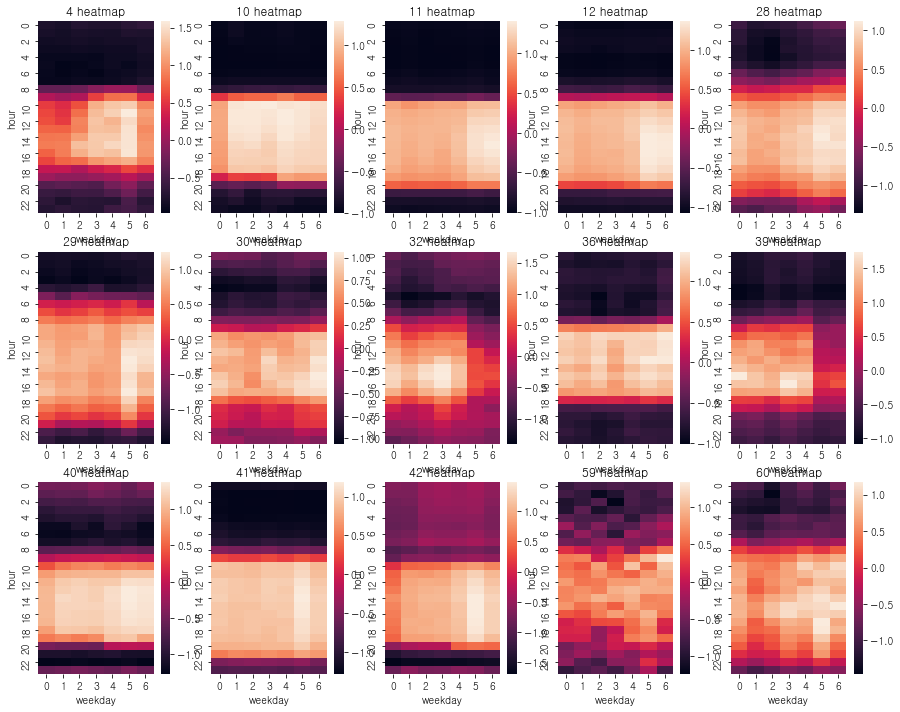

In [35]:
fig = plt.figure(figsize=(15, np.ceil(len(km_2)/5)*4))
for i, n in enumerate(km_2):
    plt.subplot(np.ceil(len(km_2)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

- 평일과 주말을 구분하지 않고 전력사용량이 이어지고 있습니다.
- 특히나 10~10 시간대에 주로 전력사용량이 집중되어 있습니다.
- 오피스형 건물의 패턴을 보였던 전략가형 건물과는 다르게, 상업용 건물이라고 추정됩니다.

In [36]:
cl_2_url = 'https://user-images.githubusercontent.com/52409420/122412399-7b0c3480-cfc0-11eb-9cae-c7090bfb37da.png'
Image(url=cl_2_url, width=250)

- 평일, 주말 상관없이 상업 시간대에 열심히 활동하는 사교적인 **외교관형 건물**이라고 하겠습니다.

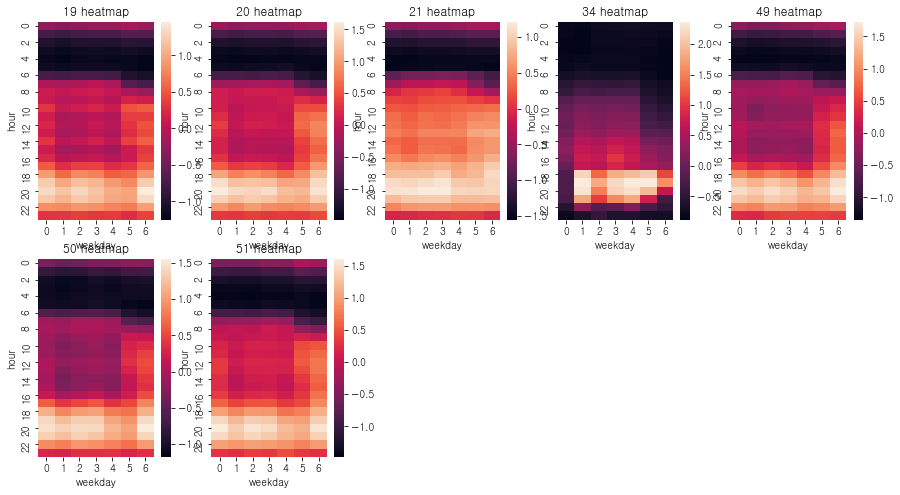

In [37]:
fig = plt.figure(figsize=(15, np.ceil(len(km_3)/5)*4))
for i, n in enumerate(km_3):
    plt.subplot(np.ceil(len(km_3)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

- 마지막 유형은 상업형 건물인 외교관형 건물과 유사하지만, 밤에 전력사용량이 집중되어 있습니다.
- 평일 낮에는 사용량이 낮은 편이며, 평일 밤과 주말 동안 전력사용량이 증가합니다.
- 자정까지 전력사용량이 이어지는 것으로 보아 밤 늦게까지 전력을 사용하는 건물유형입니다.

In [38]:
cl_3_url = 'https://user-images.githubusercontent.com/52409420/122412360-747dbd00-cfc0-11eb-8651-36b9d616f6f7.png'
Image(url=cl_3_url, width=250)

- 평일 밤 늦게까지, 주말에 더 열심히 전력을 사용하는 재기발랄한 **활동가형 건물**이라고 하겠습니다.

### 2.1.3 정리

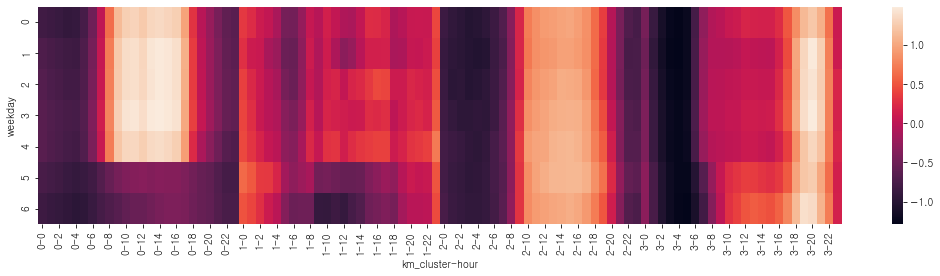

In [39]:
plt.figure(figsize=(18, 4))
sns.heatmap(train_cl.groupby(['km_cluster', 'hour', 'weekday'])['target'].mean().unstack().T)
plt.show()

- 전략가형 건물
    1. 업무 시간인 9-6 시간대에 가장 높은 전력사용량을 보이며
    2. 주말과 새벽 시간에 사용량이 줄어드는 것을 알 수 있습니다.
    3. **고층에는 사무실, 저층에는 상업 시설이 공존하는 오피스형 건물로 추정합니다.**<br>
<br>
- 연예인형 건물
    1. 같은 유형의 건물들로 뭉쳤지만, 하나로 묶을 수 없는 다양한 패턴의 전력사용량을 보이며,
    2. 다른 유형의 건물들과는 섞일 수 없는 독특한 패턴을 보이는 건물들입니다.<br>
<br>
- 외교관형 건물
    1. 상업 시간인 10-10 시간대에 가장 높은 전력사용량을 보이며
    2. 평일주말 구분이 없이 유지됩니다. 그러나 심야에는 문을 닫습니다.
    3. **일반적인 상업 시설이 존재하는 상가형 건물로 추정합니다.**<br>
<br>
- 활동가형 건물
    1. 외교관형 건물과 비슷하지만, 저녁 시간에 전력 사용량이 집중되어 있으며,
    2. 심야에도 전력 사용량이 이어지는 차이점을 보입니다.
    3. 즉, 상업 시설이지만 밤 늦게 영업하는 **술집 등이 있는 번화가형 건물로 추정합니다.**

재미로 MBTI 유형을 빗대어서 4개의 유형을 분류해보았습니다.<br>
건물의 유형에 따라 특정 시간대에 전력 사용량이 몰리는 것을 알 수 있고,<br>
그를 통해 패턴과 용도를 적당히 유추할 수 있습니다.<br>
유형별로 전력 사용량이 몰리는 시간대를 중심으로 전력 사용을 절약할 수 있는 방법이 필요할 것 같습니다.

## 2.2 시간 변수에 대한 분석

### 2.2.1 유사한 패턴을 보이던 전략가형, 외교관형, 활동가형 건물들

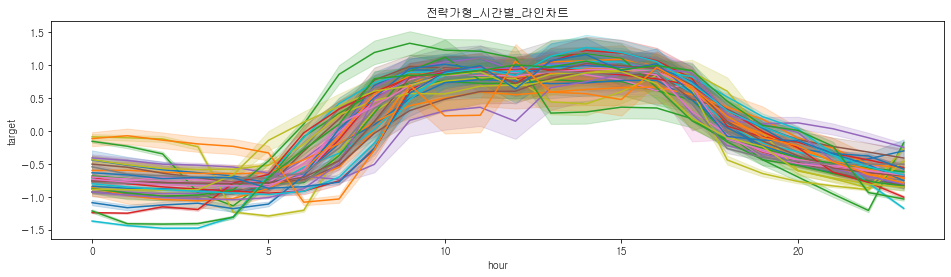

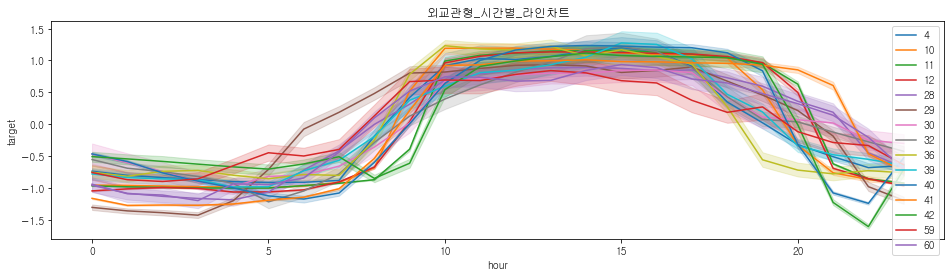

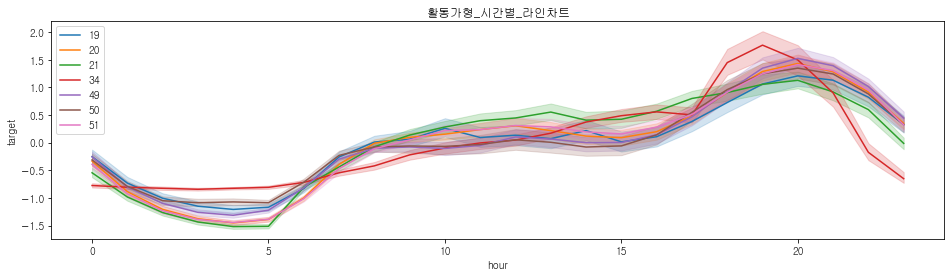

In [40]:
fig = plt.figure(figsize = (16,4))
for i in list(train_cl.loc[train_cl.km_cluster == 0].num.unique()):
    sns.lineplot(data=train_cl.loc[(train_cl.km_cluster == 0) & (train_cl.num == i)], x='hour', y='target')
plt.title('전략가형_시간별_라인차트')

fig = plt.figure(figsize = (16,4))
for i in list(train_cl.loc[train_cl.km_cluster == 2].num.unique()):
    sns.lineplot(data=train_cl.loc[(train_cl.km_cluster == 2) & (train_cl.num == i)], x='hour', y='target')
plt.title('외교관형_시간별_라인차트')
plt.legend(list(train_cl.loc[train_cl.km_cluster == 2].num.unique()))
    
fig = plt.figure(figsize = (16,4))
for i in list(train_cl.loc[train_cl.km_cluster == 3].num.unique()):
    sns.lineplot(data=train_cl.loc[(train_cl.km_cluster == 3) & (train_cl.num == i)], x='hour', y='target')
plt.title('활동가형_시간별_라인차트')
plt.legend(list(train_cl.loc[train_cl.km_cluster == 3].num.unique()))

- 다소 편차는 존재하지만, 대체로 유형별로 비슷한 패턴을 보이고 있습니다.
- 활동가형에서는 34번이 다른 양상을 보이고 있습니다.

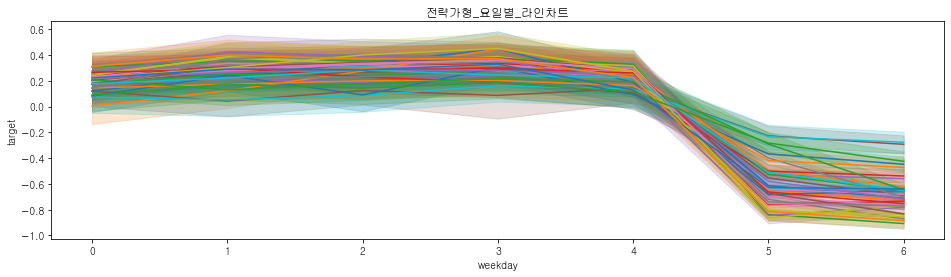

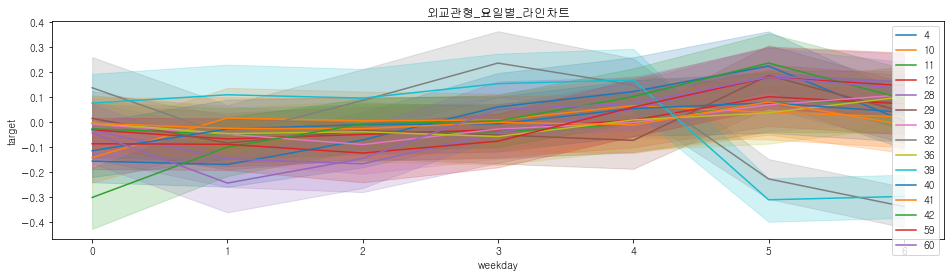

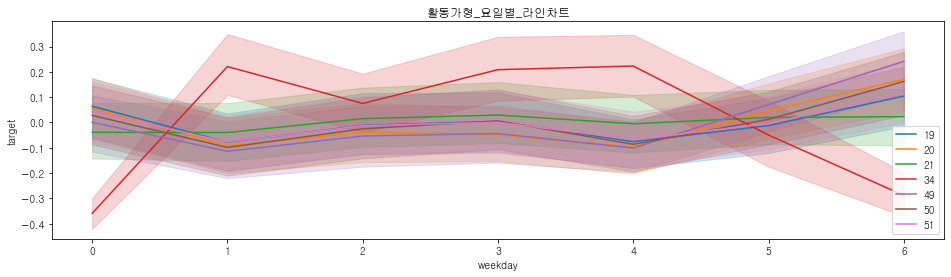

In [41]:
fig = plt.figure(figsize = (16,4))
for i in list(train_cl.loc[train_cl.km_cluster == 0].num.unique()):
    sns.lineplot(data=train_cl.loc[(train_cl.km_cluster == 0) & (train_cl.num == i)], x='weekday', y='target')
plt.title('전략가형_요일별_라인차트')

fig = plt.figure(figsize = (16,4))
for i in list(train_cl.loc[train_cl.km_cluster == 2].num.unique()):
    sns.lineplot(data=train_cl.loc[(train_cl.km_cluster == 2) & (train_cl.num == i)], x='weekday', y='target')
plt.title('외교관형_요일별_라인차트')
plt.legend(list(train_cl.loc[train_cl.km_cluster == 2].num.unique()))

fig = plt.figure(figsize = (16,4))
for i in list(train_cl.loc[train_cl.km_cluster == 3].num.unique()):
    sns.lineplot(data=train_cl.loc[(train_cl.km_cluster == 3) & (train_cl.num == i)], x='weekday', y='target')
plt.title('활동가형_요일별_라인차트')
plt.legend(list(train_cl.loc[train_cl.km_cluster == 3].num.unique()))

- 요일별 평균 전력 사용량에서도 유형별로 유사한 패턴을 보입니다.
- 외교관형에서 39번과 32번이 다소 상이한 패턴을 보이고 있습니다. 전력가형과 오히려 유사해보입니다.
- 활동가형에서는 34번이 다소 상이한 패턴을 보입니다. 어느 유형에도 속하지 않는 패턴입니다.

In [42]:
outlier_sample = [2, 4, 39, 32, 34]

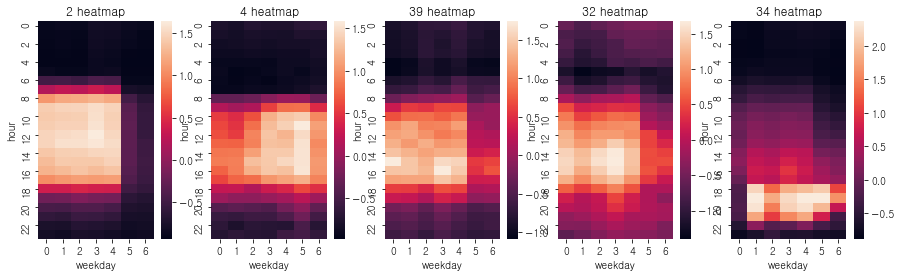

In [43]:
fig = plt.figure(figsize=(15, np.ceil(len(outlier_sample)/5)*4))
for i, n in enumerate(outlier_sample):
    plt.subplot(np.ceil(len(outlier_sample)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

- 39, 32번 건물은 같은 유형인 4번에 비해 주말 전력 사용량이 많지 않습니다. 다만 전략가형의 2번과는 다르게 주말에도 전력 사용량이 일부 유지되는 패턴입니다.
- 34번은 저녁에만 영업을 하는 유형의 건물입니다.

### 2.2.2 유사한 패턴을 보이지 않던 연예인형의 건물들

연예인형의 건물들을 따로 살펴보겠습니다.

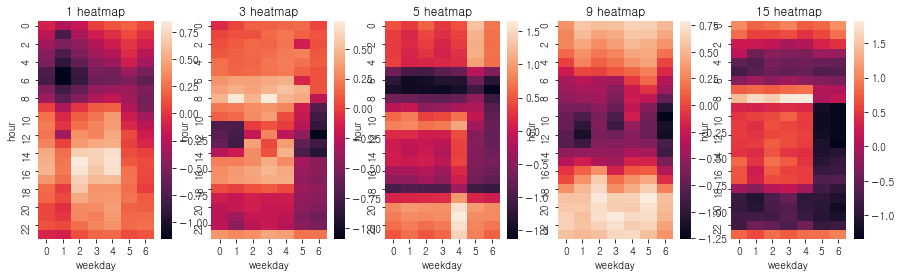

In [44]:
fig = plt.figure(figsize=(15, np.ceil(len(km_1)/5)*4))
for i, n in enumerate(km_1):
    plt.subplot(np.ceil(len(km_1)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

In [45]:
# 기상의 영향을 받지 않는 연예인형의 건물들과
# 기상의 영향을 매우 많이 받으며, 외교관형의 건물인 32번 건물 
# 비교를 위한 전략가형의 2번 건물, 활동가형의 20번 건물
weird_sample = [2, 20, 32, 1, 3, 5, 9, 15]

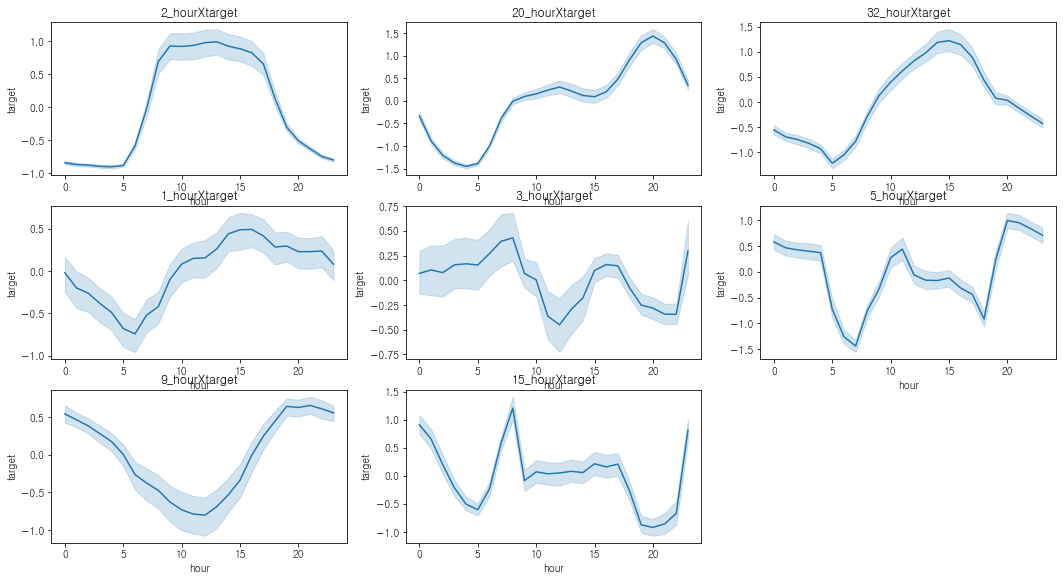

In [46]:
fig = plt.figure(figsize=(18, 40))
for i, n in enumerate(weird_sample):
    plt.subplot(12, 3, i+1)
    plt.title("{}_hourXtarget".format(n))
    sns.lineplot(data=train.loc[train.num == n], x='hour', y='target')

보통의 경우에는 32번 건물처럼 5시 즈음에 저점을 찍고, 15시 즈음에 고점을 찍는 동산형 모양을 띕니다.

- 1번 건물은 32번과 그나마 유사합니다. 다만 편차가 조금 클 뿐이고, 범위가 넓게 형성되고 있습니다.
- 3번 건물은 아침에 고점을 찍고, 정오에 저점을 찍었다가, 저녁에 다시 올랐다가 밤에 다시 내려갑니다. 거리를 돌아다니면서 이런 유형의 건물이 무엇이 있을까 고민하고 있지만, 아직은 찾지 못했습니다.
- 9번 건물은 낮에 전력을 거의 사용하지 않고, 밤부터 급격히 상승합니다. 밤에만 문을 여는 건물이 있는 것 같습니다.
- 15번 건물 또한 아침에 고점을 찍습니다. 그리고 밤에 다시 상승합니다.

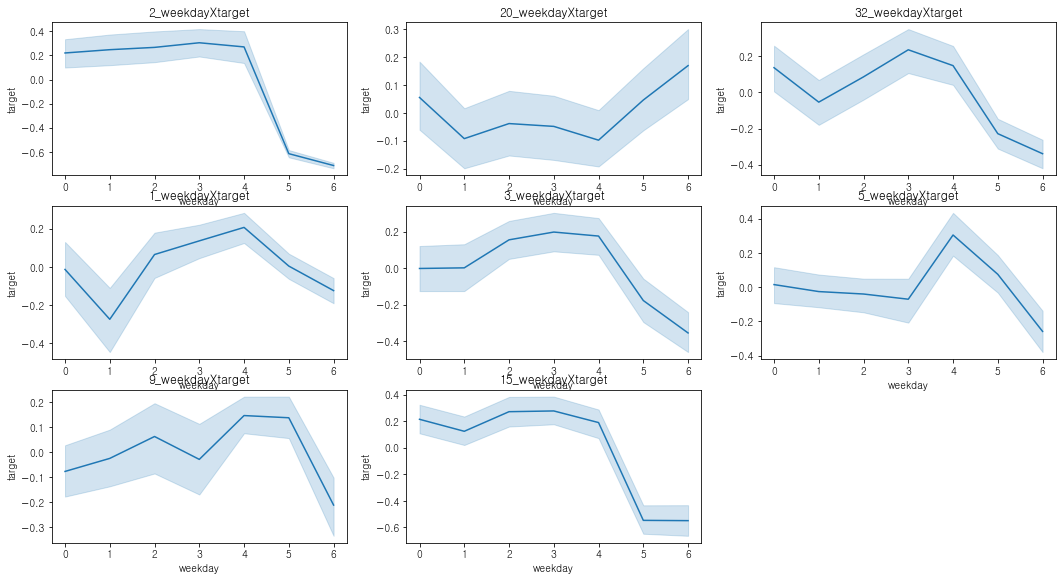

In [47]:
fig = plt.figure(figsize=(18, 40))
for i, n in enumerate(weird_sample):
    plt.subplot(12, 3, i+1)
    plt.title("{}_weekdayXtarget".format(n))
    sns.lineplot(data=train.loc[train.num == n], x='weekday', y='target')

요일별 패턴은 그래도 유사한 점이 있습니다.

- 32번과 유사하게, 모든 건물에서 주말(5~6)에는 사용량이 줄어듭니다.
- 32번과 유사하게, 많은 건물에서 목 ~ 금요일(3~4)에 가장 높은 사용량을 보이고 있습니다.
- 그러나 이 또한 유사한 규칙성을 보이지는 않고 있습니다.

### 2.2.3 정리

- 전략가형, 외교관형, 활동가형의 건물들은 기상 변수의 영향을 다소 받으며, 시간 변수의 영향도 비슷한 패턴을 보이고 있습니다.
- 그러나 연예인형의 변수는 기상 변수의 영향도 적으면서, 시간 변수의 패턴도 상이하게 나타나고 있습니다.
- 연예인형의 건물들을 같은 클러스터로 묶는 것은 다소 무리가 있을 것으로 판단되기도 합니다.
- 외교관형의 32, 39번 건물과 활동가형의 34번 건물은 군집의 다른 건물들과 다소 다른 패턴을 보이고 있습니다.

## 2.3 기상 변수에 대한 상관 분석: 날씨는 얼마나 중요할까?

### 2.3.1 상관계수 구하기

피어슨 상관계수를 사용했습니다.

In [48]:
from scipy.stats import pearsonr

In [49]:
corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].temp,
                       train.loc[train.num == i].target)
    corrs.append(corr)

In [50]:
corrs_temp = train_cl.groupby(['km_cluster', 'num'])['target'].mean().to_frame()

In [51]:
temp = train_cl.groupby(['num'])['cooler', 'solar'].max()

In [52]:
# 건물별로, 기상요인별로 상관계수를 계산해줍니다.
corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].temp,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['temp_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].humid,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['humid_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].sunny,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['sunny_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].wind,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['wind_corr'] = corrs

In [53]:
corrs_cl_temp = pd.merge(corrs_temp, temp, how='left', on='num').set_index(corrs_temp.index).round(2)

### 2.3.2 기온의 영향을 많이 받는 건물

In [54]:
corrs_temp_temp = (corrs_cl_temp.temp_corr
                   .reset_index()
                   .sort_values(by=['temp_corr'], ascending=False)
                  .set_index(['num'], drop=False))

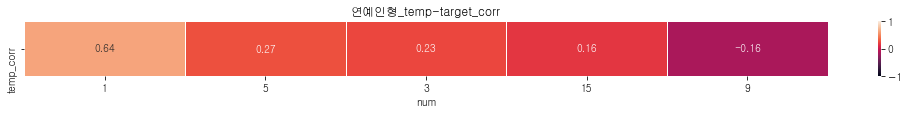

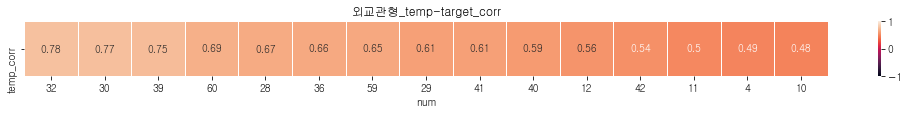

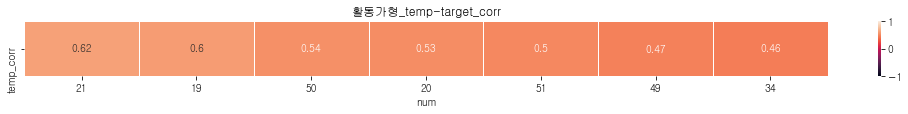

In [55]:
plt.figure(figsize=(18, 1))
plt.title('전략가형_temp-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 0]['temp_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('연예인형_temp-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 1]['temp_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('외교관형_temp-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 2]['temp_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('활동가형_temp-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 3]['temp_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

- 전략가형의 건물들은 높은 양의 상관성을 띄는 건물들도 있으나, 대체로 낮은 상관성을 띕니다.
- 연예인형의 건물들은 1번 건물을 제외하고서는 기온에 따른 상관성이 뚜렷하지 않습니다.
- 외교관형의 건물들이 가장 높은 상관성을 보이며, 활동가형은 전략가형과 유사해보입니다.

높은 양의 상관성을 띄는 32, 31번, 상관성을 띄지 않는 5, 3, 15, 9 번을 살펴보겠습니다.

In [56]:
temp_sample = [32, 31, 5, 3, 15, 9]

In [57]:
fig = plt.figure(figsize=(18, 40))
for i, n in enumerate(temp_sample):
    plt.subplot(12, 6, i+1)
    plt.title("{}_tempXtarget".format(n))
    sns.regplot(data=train.loc[train.num == n], x='temp', y='target')

32, 31번 건물은 아주 뚜렷한 양의 상관관계를 나타냅니다. 다른 건물들은 기온과는 큰 의미가 없어보이는 것이 눈에 띕니다.

### 2.3.3 습도의 영향을 많이 받는 건물

In [58]:
corrs_temp_temp = (corrs_cl_temp.humid_corr
                   .reset_index()
                   .sort_values(by=['humid_corr'], ascending=True)
                  .set_index(['num'], drop=False))

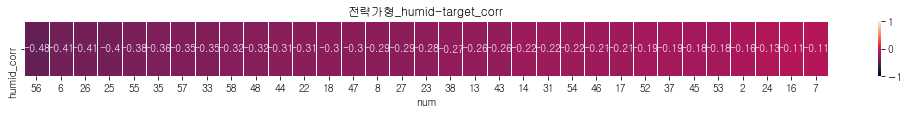

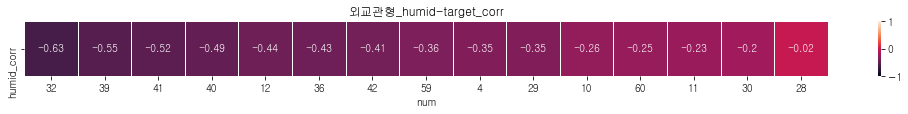

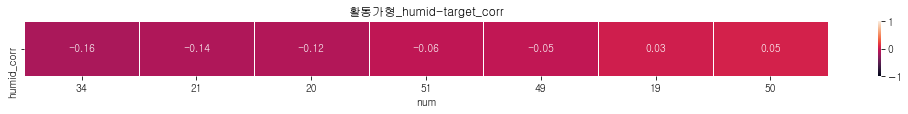

In [59]:
plt.figure(figsize=(18, 1))
plt.title('전략가형_humid-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 0]['humid_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('연예인형_humid-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 1]['humid_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('외교관형_humid-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 2]['humid_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('활동가형_humid-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 3]['humid_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

- 전략가형과 외교관형은 건물별로 다양한 스펙트럼을 보입니다.
- 연예인형은 9번을 제외하고는 습도에 따른 상관성을 보이지 않습니다.
- 9번 건물은 특이하게 양의 상관성을 띄고 있습니다.

높은 음의 상관성을 띄는 32, 39번과 상관성을 띄지 않는 50, 19번, 높은 양의 상관성을 띄는 9번과 15번을 추가로 살펴보겠습니다.

In [60]:
humid_sample = [32, 39, 50, 19, 9, 15]

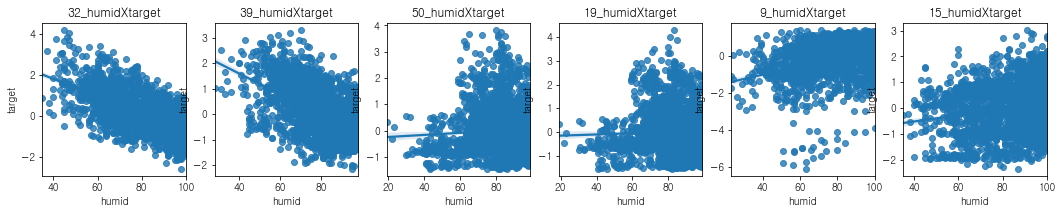

In [61]:
fig = plt.figure(figsize=(18, 40))
for i, n in enumerate(humid_sample):
    plt.subplot(12, 6, i+1)
    plt.title("{}_humidXtarget".format(n))
    sns.regplot(data=train.loc[train.num == n], x='humid', y='target')

### 2.3.4 바람의 영향을 많이 받는 건물

In [62]:
corrs_temp_temp = (corrs_cl_temp.wind_corr
                   .reset_index()
                   .sort_values(by=['wind_corr'], ascending=False)
                  .set_index(['num'], drop=False))

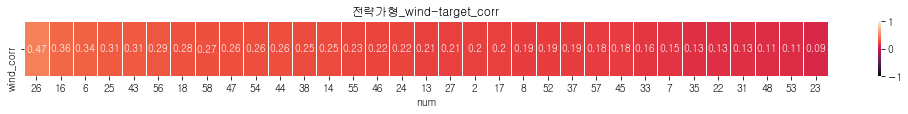

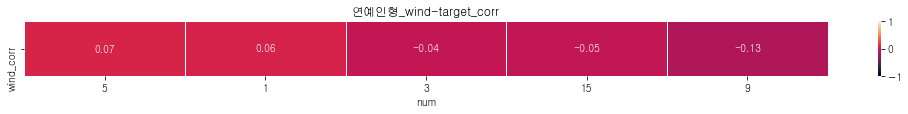

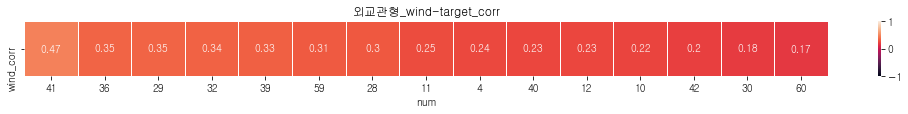

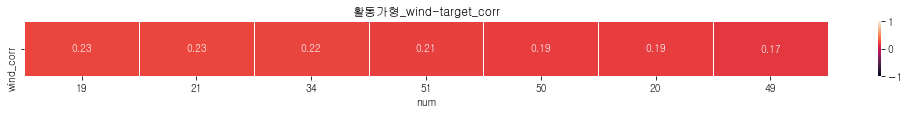

In [63]:
plt.figure(figsize=(18, 1))
plt.title('전략가형_wind-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 0]['wind_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('연예인형_wind-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 1]['wind_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('외교관형_wind-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 2]['wind_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('활동가형_wind-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 3]['wind_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

- 여전히 전략가형, 외교관형 유형의 건물은 다양한 스펙트럼을 보입니다.
- 연예인형의 건물들은 바람에도 큰 영향을 받지 않습니다.
- 활동가형도 마찬가지로 크게 뚜렷한 상관성을 보이지 않습니다.

In [64]:
wind_sample = [26, 41, 19, 21, 5, 9]

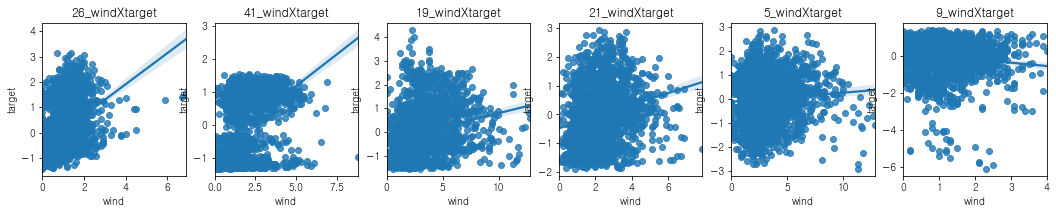

In [65]:
fig = plt.figure(figsize=(18, 40))
for i, n in enumerate(wind_sample):
    plt.subplot(12, 6, i+1)
    plt.title("{}_windXtarget".format(n))
    sns.regplot(data=train.loc[train.num == n], x='wind', y='target')

바람은 역시 전체적으로 유의미한 상관성을 보이지는 않고 있습니다.

### 2.3.5 정리

In [66]:
corrs_temp_temp = (corrs_cl_temp[['temp_corr', 'humid_corr', 'wind_corr']]
                   .reset_index()
                   .sort_values(by=['temp_corr', 'humid_corr', 'wind_corr'], ascending=False)
                  .set_index(['num'], drop=False))

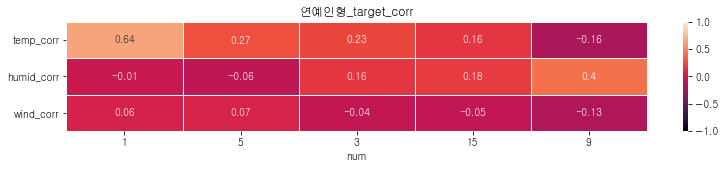

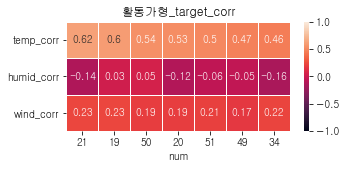

In [67]:
plt.figure(figsize=(22, 2))
plt.title('전략가형_target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 0][['temp_corr','humid_corr', 'wind_corr']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(13, 2))
plt.title('연예인형_target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 1][['temp_corr', 'humid_corr', 'wind_corr']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(10, 2))
plt.title('외교관형_target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 2][['temp_corr', 'humid_corr', 'wind_corr']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(5, 2))
plt.title('활동가형_target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 3][['temp_corr', 'humid_corr', 'wind_corr']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

- 기상의 영향을 많이 받는 건물이라면, 기온에 대한 양의 상관관계, 습도에 대한 음의 상관관계를 띄운다고 볼 수 있습니다.
- 대표적으로 외교관형의 32번, 39번 건물이 있습니다.
- 반면에 기상의 영향을 많이 받지 않는 건물이 있는데, 주로 연예인형의 건물들이라고 볼 수 있습니다.
- 연예인형의 건물들 중 3, 5, 15 건물은 기온과 습도에 대한 뚜렷한 상관성을 보이지 않고 있습니다.
- 9번 건물은 특이하게도 습도에 대한 양의 상관관계를 가지고 있습니다.
- 1번 건물은 특이하게도 습도와 바람과는 상관없이 오직 기온에 대해서만 높은 상관성을 띄고 있습니다.
- 바람에 대한 상관계수는 0.45를 넘는 26번, 41번을 제외하고는 0.35 이하이기 때문에 뚜렷한 상관성을 띈다고는 볼 수 없습니다.

기상의 영향을 많이 받는 건물은 기상 예보 데이터를 통해 전력 사용량 예측이 가능할 것입니다.<br>
또한 이러한 건물의 경우 기상의 영향을 낮출 수 있는 방법을 통해 전력 사용량을 낮출 수 있을 것입니다.<br>

## 2.4 건물 시스템 변수에 대한 상관 분석: Cooler와 Solar는 효과가 있을까?

본 데이터에서 유일하게 건물의 정보로 제공된 비전기 냉방 시스템 설치 여부(Cooler), 태양광 발전 시스템 설치 여부(Solar)는 전력 소모량을 줄일 수 있는 시스템입니다.

- Cooler: 전기 소모 없이 냉방을 하여 전력 소모 절약
- Solar: 태양광 발전을 통해 전력 소모 절약

즉, 이 두 시스템이 설치 된 건물이 다른 건물보다 유의미한 차이가 있는지 살펴보고자 합니다.

### 2.4.1 건물 유형별 설치 여부 확인

In [68]:
cs_temp = train_cl.groupby(['km_cluster', 'num']).max().reset_index().groupby(['km_cluster'])['cooler', 'solar'].sum()

In [69]:
double_temp = train_cl[['km_cluster', 'num', 'solar', 'cooler']].drop_duplicates().set_index('num')
double_temp['double'] = double_temp.solar + double_temp.cooler

In [70]:
cs_temp['double'] = double_temp.loc[double_temp.double == 2].km_cluster.value_counts()

In [71]:
cs_temp['buildings'] = train_cl.groupby(['km_cluster'])['num'].count()/2040

In [72]:
cs_temp['cooler_rate'] = cs_temp.cooler / cs_temp.buildings
cs_temp['solar_rate'] = cs_temp.solar / cs_temp.buildings
cs_temp['double_rate'] = cs_temp.double / cs_temp.buildings

In [73]:
cs_temp

cooler  solar  double  buildings  cooler_rate  solar_rate  \
km_cluster                                                              
0             26.0   16.0      12       33.0     0.787879    0.484848   
1              3.0    2.0       1        5.0     0.600000    0.400000   
2             11.0    8.0       7       15.0     0.733333    0.533333   
3              1.0    3.0       1        7.0     0.142857    0.428571   

            double_rate  
km_cluster               
0              0.363636  
1              0.200000  
2              0.466667  
3              0.142857

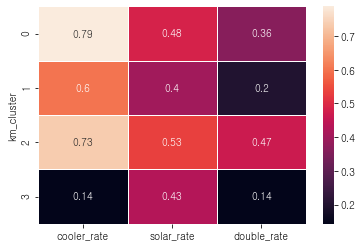

In [74]:
sns.heatmap(cs_temp[['cooler_rate', 'solar_rate', 'double_rate']],
           annot=True, linewidths=.5)
plt.show()

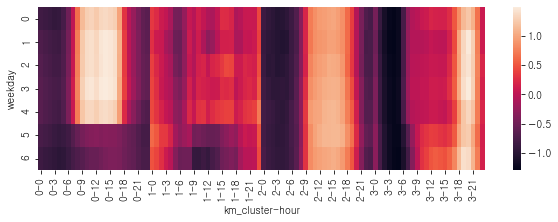

In [75]:
# 클러스터들이 어떤 유형의 건물들이었는지 까먹어서 다시 불러온 코드
plt.figure(figsize=(10, 3))
sns.heatmap(train_cl.groupby(['km_cluster', 'hour', 'weekday'])['target'].mean().unstack().T)
plt.show()

- solar는 모든 건물 유형에서 유사한 비율을 가지고 있습니다.
- cooler는 유형별로 매우 편차가 큽니다.
- 전략가형은 전략적으로 79%가 설치한 반면, 활동가형은 14%만 설치하였습니다.
- 주간에 전력사용량이 집중되어 있는 전략가형, 외교관형의 경우 cooler의 설치 비율이 높고,
- 밤에 주로 활동을 하는 활동가형은 cooler를 설치하지 않은 것으로 보입니다.

### 2.4.2. 건물별 상관계수 분석

- Cooler는 기온이 높아질수록 냉방이 필요할테니 temp와의 상관계수 계산하겠습니다.
- Solar는 일조시간이 길어질수록 전력 생산량이 늘어날테니 sunny와의 상관계수 계산하겠습니다.

In [76]:
corrs_system_temp = (corrs_cl_temp[['cooler', 'temp_corr', 'sunny_corr', 'solar']]
                   .reset_index()
                   .sort_values(by=['cooler', 'solar'], ascending=False)
                  .set_index(['num'], drop=False))

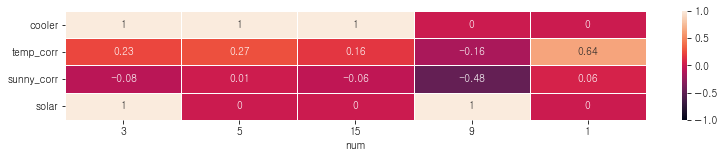

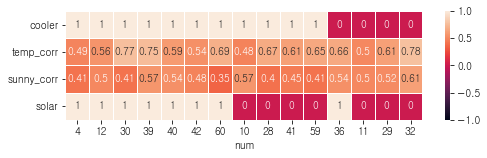

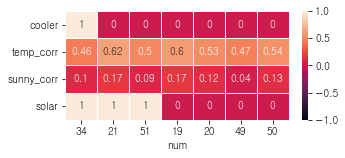

In [77]:
plt.figure(figsize=(22, 2))
sns.heatmap(corrs_system_temp.loc[corrs_system_temp.km_cluster == 0][['cooler', 'temp_corr', 'sunny_corr', 'solar']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(13, 2))
sns.heatmap(corrs_system_temp.loc[corrs_system_temp.km_cluster == 1][['cooler', 'temp_corr', 'sunny_corr', 'solar']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(8, 2))
sns.heatmap(corrs_system_temp.loc[corrs_system_temp.km_cluster == 2][['cooler', 'temp_corr', 'sunny_corr', 'solar']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(5, 2))
sns.heatmap(corrs_system_temp.loc[corrs_system_temp.km_cluster == 3][['cooler', 'temp_corr', 'sunny_corr', 'solar']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

- 이렇게 보아서는 뚜렷한 관계성을 찾아볼 수 없습니다.

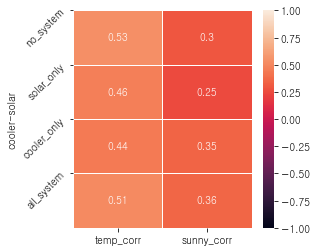

In [78]:
plt.figure(figsize=(4, 4))
sns.heatmap(corrs_cl_temp.groupby(['cooler', 'solar'])[['temp_corr', 'sunny_corr']].mean(),
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.yticks([0, 1, 2, 3], ['no_system', 'solar_only', 'cooler_only', 'all_system'], rotation=45)
plt.show()

- 설치 여부에 따른 건물 유형별로 평균을 비교해봐도 뚜렷한 차이를 알 수 없습니다.

### 2.4.3 피크 시간 비교

#### 2.4.3.1 냉방 시스템

동일한 요일의 동일한 시간에 냉방 시스템의 유무에 따른 산점도를 비교해보겠습니다.

In [79]:
peak_df_0_1 = train_cl.loc[(train_cl.weekday == 2) & (train_cl.hour == 14) & (train_cl.cooler == 1)]
peak_df_0_0 = train_cl.loc[(train_cl.weekday == 2) & (train_cl.hour == 14) & (train_cl.cooler == 0)]

In [80]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title("cooler_on")
sns.regplot(data=peak_df_0_1, x='temp', y='target')
plt.ylim(top=4, bottom=-3)

plt.subplot(1, 2, 2)
plt.title("cooler_off")
sns.regplot(data=peak_df_0_0, x='temp', y='target')
plt.ylim(top=4, bottom=-3)

plt.show()

- Cooler를 설치한 건물과 설치하지 않은 건물의 뚜렷한 차이는 보이지 않습니다.
- 다만 주목할 만 한 점은 Cooler를 설치한 건물은 기온 대비 전력 소모량이 다소 높게 형성이 되어 있습니다.
- 즉, Cooler를 설치하지 않은 건물들 대비, 절대적인 전력 소모량이 많은 건물들일 가능성이 높습니다.

건물들을 하나씩 살펴보겠습니다.

In [81]:
fig = plt.figure(figsize=(18, 40))
for i, n in enumerate(peak_df_0_1.num.unique()):
    plt.subplot(12, 6, i+1)
    plt.title("{}_tempXtarget".format(n))
    sns.regplot(data=peak_df_0_1.loc[peak_df_0_1.num == n], x='temp', y='target')
    plt.ylim(top=4, bottom=-3)

대다수의 건물들의 플롯이 상단에 형성되어 있는 것을 볼 수 있습니다.

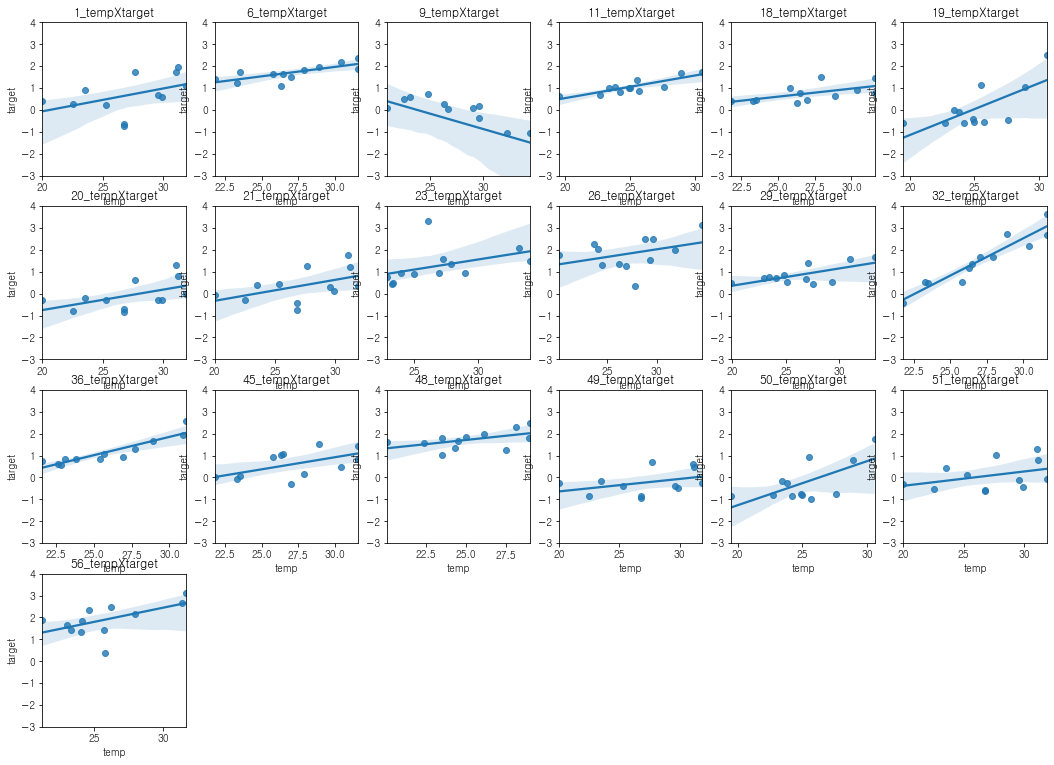

In [82]:
fig = plt.figure(figsize=(18, 40))
for i, n in enumerate(peak_df_0_0.num.unique()):
    plt.subplot(12, 6, i+1)
    plt.title("{}_tempXtarget".format(n))
    sns.regplot(data=peak_df_0_0.loc[peak_df_0_0.num == n], x='temp', y='target')
    plt.ylim(top=4, bottom=-3)

반면에 Cooler를 설치하지 않은 건물들은 상대적으로 절대적인 전력 소모량이 적은 것을 알 수 있습니다.

- 정리하자면, Cooler를 설치한 건물들과 설치하지 않은 건물들에서 설치 여부에 따른 전력 소모량 차이는 크지 않아 보입니다.
- 그러나 Cooler를 설치한 건물들은 설치하지 않은 건물보다 절대적인 전력 소모량이 많은 것으로 파악됩니다.
- Cooler 설치 여부에 따른 전력 소모량의 관계를 정확히 밝혀낼 수는 없지만, 전력 소모량이 많은 건물들 위주로 Cooler를 설치했다는 것을 유추할 수 있습니다.

#### 2.4.3.2 태양광 시스템

태양광 발전 시스템은 태양광을 통해서 전력을 생산하고 즉시 사용하는 시스템입니다.<br>
따라서 일조시간이 길어지는 날에는 일조시간이 적은 날보다 전력 소모량이 적을 것으로 추측할 수 있습니다.<br>
이를 비교하기 위해서는 기온이 비슷하지만 일조 시간이 다른 두 날을 비교해보는 것입니다.

In [83]:
solar_temp = train_cl.groupby(['km_cluster', 'num', 'dayofyear'])[['target', 'sunny', 'solar']].sum().reset_index()

In [84]:
peak_df_1_1 = solar_temp.loc[solar_temp.solar != 0]
peak_df_1_0 = solar_temp.loc[solar_temp.solar == 0]

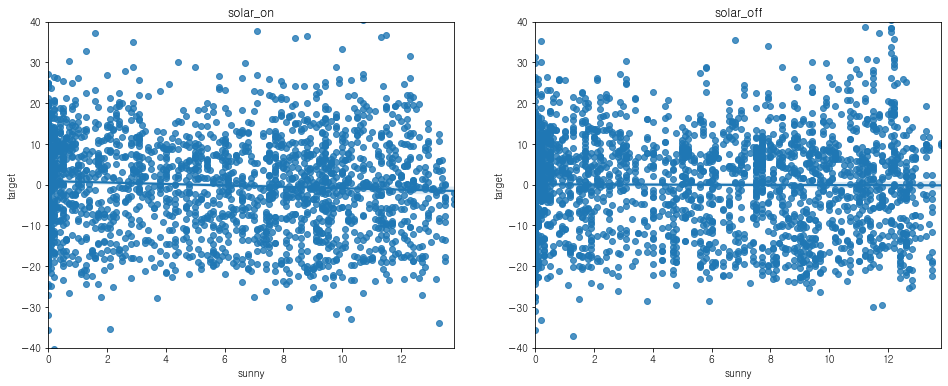

In [85]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title("solar_on")
sns.regplot(data=peak_df_1_1, x='sunny', y='target')
plt.ylim(top=40, bottom=-40)

plt.subplot(1, 2, 2)
plt.title("solar_off")
sns.regplot(data=peak_df_1_0, x='sunny', y='target')
plt.ylim(top=40, bottom=-40)

plt.show()

태양광 시스템 설치 여부로는 일조시간과 전력 소모량의 유의미한 차이가 보이지 않습니다.

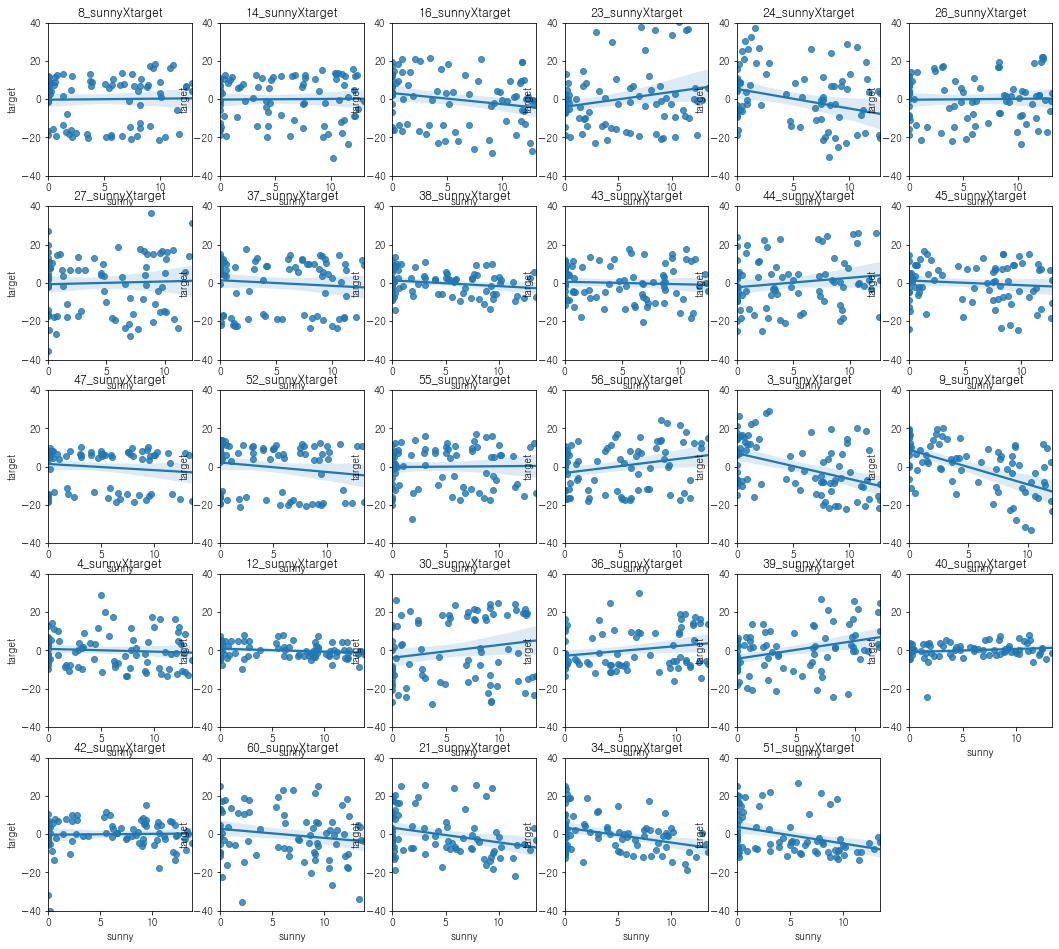

In [86]:
fig = plt.figure(figsize=(18, 40))
for i, n in enumerate(peak_df_1_1.num.unique()):
    plt.subplot(12, 6, i+1)
    plt.title("{}_sunnyXtarget".format(n))
    sns.regplot(data=peak_df_1_1.loc[peak_df_1_1.num == n], x='sunny', y='target')
    plt.ylim(top=40, bottom=-40)

In [87]:
fig = plt.figure(figsize=(18, 40))
for i, n in enumerate(peak_df_1_0.num.unique()):
    plt.subplot(12, 6, i+1)
    plt.title("{}_sunnyXtarget".format(n))
    sns.regplot(data=peak_df_1_0.loc[peak_df_1_0.num == n], x='sunny', y='target')
    plt.ylim(top=40, bottom=-40)

건물별로 살펴보아도 명확히 구분짓지 못하겠습니다. 태양광 발전 시스템의 경우 심도 있는 고민이 필요할 것으로 보입니다.<br>
태양광 발전 시스템으로 인해 생산하는 전력량이 어느 정도인지, 생산한 전기를 즉시 사용하는지, Lag가 있는지도 중요할 것으로 보입니다.

# 3. 군집별 예측 모델 구축

**데이터 패턴이 비슷한 군집별로 모델링 진행**
- 60개 건물의 데이터를 하나의 모델로 학습시키면 데이터가 많아 Bias는 줄일 수 있으나, Variance는 증가할 수 있습니다. 전력사용량을 설명할 수 있는 변수가 많지 않은 반면에 군집별로 데이터의 패턴이 너무 다르기 때문입니다.
- 그러나 60개 건물을 모두 따로 모델링하면 Variance는 줄일 수 있으나, 데이터가 적어 Bias가 증가할 수 있습니다. 각 건물의 레코드가 2040개 밖에 되지 않기 때문입니다. 또한 코스트가 많이 소모되고, 제공된 컬럼인 Cooler와 Solar를 포기해야 합니다.
- 따라서 최대한 데이터의 패턴이 비슷한 건물들을 모아서 군집별로 모델을 구축하겠습니다.



**그러나 군집에 포함할 수 없는 건물은 별도 모델링**
- 다만 데이터 패턴이 다른 건물들과 유사하지 않은 건물들은 굳이 군집에 포함하지 않고 별도의 모델링을 하면서 성능을 비교하겠습니다.
- 데이터 패턴이 많이 다른 건물 데이터가 군집 모델에 포함되는 것보다 따로 모델을 만드는 것이 전체 성능에 도움이 될 수 있습니다.
- 최대한 코스트를 줄이면서도 성능을 높일 수 있는 합의점을 찾는 방식으로 진행했습니다.

## 3.1 Random Forest OOB Score를 통한 모델 설명력 확인

**건물별 모델 설명력 확인 근거**
- 동일한 변수와 동일한 알고리즘으로 건물별로 각각 학습시켰을 때, 특정 건물의 설명력이 다른 건물보다 떨어진다면 해당 건물의 데이터에서는 독립변수가 종속변수를 설명하지 못한다는 것을 뜻합니다. 즉, 다른 건물들과 함께 군집에 포함시키는데 무리가 있을 것으로 판단 됩니다.
- 따라서 60개의 건물들을 전부 따로 모델링하여 설명력을 확인하고, 군집 모델링 근거 지표로 확인하고자 합니다.




**Random Forest 알고리즘 사용 근거**
- 데이터가 많지 않을 때는 부스팅 알고리즘보다 배깅 알고리즘이 과대적합을 방지하면서 높은 성능을 낼 수 있습니다.
- 특히나 배깅 알고리즘은 부트스트랩핑의 특징으로서 OOB가 발생하고, 이를 통해 Train Set과 Valid Set을 나누지 않더라도 Validation이 가능합니다. 즉, 주어진 데이터를 전부 사용하면서 학습과 밸리데이션이 동시에 가능합니다.
- 따라서 Random Forest OOB Score를 통해 모델 설명력을 확인하고, 차이가 나는 건물은 별도로 모델링을 하여 군집모델의 성능을 높이겠습니다.

In [99]:
train = pd.read_csv(PATH + '\\train.csv', encoding='cp949', names=train_col, header=0)
test = pd.read_csv(PATH + '\\test.csv', encoding='cp949', names=test_col, header=0)
sub = pd.read_csv(PATH + '\\sample_submission.csv', encoding='cp949')

In [100]:
train = make_time(train)
test = make_time(test)

In [101]:
for i in range(1, 61):
    test.loc[test.num == i, 'cooler'] = train.loc[train.num == i, 'cooler'].mean()
    test.loc[test.num == i, 'solar'] = train.loc[train.num == i, 'solar'].mean()

In [102]:
test[['temp', 'wind', 'humid', 'rain', 'sunny']] = test[['temp', 'wind', 'humid', 'rain', 'sunny']].interpolate(method='values').round(1)

In [103]:
train.loc[train.weekday >= 5, 'holiday'] = True
train.loc[train.weekday < 5, 'holiday'] = False
train.loc[(train.month == 8) & (train.day == 17), 'holiday'] = True

test.loc[test.weekday >= 5, 'holiday'] = True
test.loc[test.weekday < 5, 'holiday'] = False

train.holiday = train.holiday.astype('bool')
test.holiday = test.holiday.astype('bool')

In [104]:
train.drop(['date_time'], axis=1, inplace=True)
test.drop(['date_time'], axis=1, inplace=True)

In [105]:
preds = []
oob_scores = []
for i in tqdm(range(1, 61)):
    # 건물별로 데이터 할당
    x_train_building = train.loc[train.num == i, ~train.columns.isin(['target', 'num', 'cooler', 'solar'])]
    y_train_building = train.loc[train.num == i, 'target']
    x_test_building = test.loc[test.num == i, ~test.columns.isin(['num', 'cooler', 'solar'])]
    
    # 학습 및 예측
    rf = RandomForestRegressor(random_state=42, oob_score=True, n_jobs=-1)
    rf.fit(x_train_building, y_train_building)
    pred = rf.predict(x_test_building)
    preds.append(pred.tolist())
    oob_scores.append(rf.oob_score_)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:12<00:00,  4.94it/s]


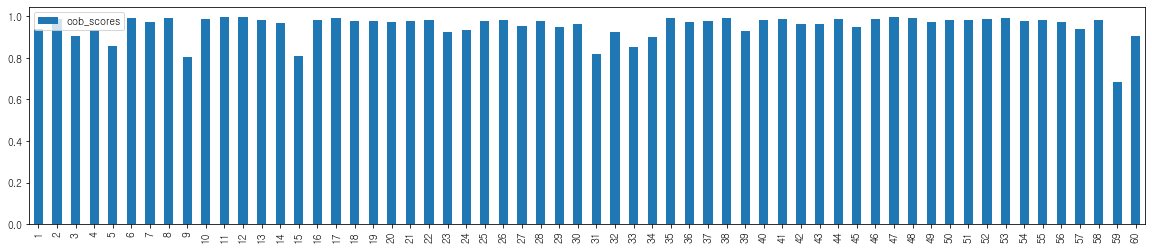

In [106]:
# 건물별 oob_score 플롯팅
pd.DataFrame(data=oob_scores, index=list(range(1, 61)), columns=['oob_scores']).plot(kind='bar', figsize=(20, 4))
plt.show()

- 두드러지게 oob_score가 낮은 건물들이 존재합니다.

In [333]:
oob_df = pd.DataFrame(data=oob_scores, index=list(range(1, 61)), columns=['oob_scores']).reset_index()
oob_df.sort_values(by=['oob_scores']).reset_index(drop=True)[:12]

index  oob_scores
0      59    0.684639
1       9    0.806504
2      15    0.809871
3      31    0.817613
4      33    0.850968
5       5    0.856544
6      34    0.902385
7      60    0.907063
8       3    0.907424
9      23    0.922888
10     32    0.923943
11     39    0.929525

- **oob_score가 0.93**보다 낮은 건물들을 별도로 모델링 하겠습니다.
- 연예인형 건물 중 **9, 15, 5, 3** 이 포함되어 있습니다. 결국 **1**번 건물만 홀로 남으므로, 연예인형 건물은 전부 건물별로 모델링을 하겠습니다.
- 그 외에 59, 31, 33, 34, 60, 23, 32, 39 건물이 포함되었습니다.
- **32, 39**번 건물은 시간 * 요일 분석에서 다른 외교관형 건물과는 다르게 주말 패턴이 다른 건물이었습니다. 또한 기상 분석에서도 가장 높은 기온 상관성과 가장 높은 습도 상관성을 띄는 독특한 건물이었습니다.
- **34**번 건물 또한 시간 * 요일 히트맵 차트를 보았을 때 다른 활동가형 건물들과는 다르게 밤에만 전력을 사용하는 건물이었습니다.
- **59, 60**번 건물은 시간 * 요일 히트맵 차트를 보았을 때 외교관형 건물 유형 중에서 패턴은 비슷하지만 세부적인 사용량의 차이가 보이던 건물입니다.
- **31, 33**번 건물은 시간 * 요일 히트맵 차트를 보았을 때 동일한 전력가형 건물들과 패턴이 유사했으나, 목요일 16시경에 갑자기 전력사용량이 급격히 떨어지는 모습을 보이는 건물이었습니다.
- **즉, 앞선 분석들에서 다소 유의한 특징을 보였던 건물들이 모델의 설명력에서도 다른 건물들과는 다소 차이를 보이는 것을 알 수 있습니다.**

## 3.2 군집 및 건물별 모델링

In [334]:
X = pd.concat([train_origin, train_cl['km_cluster']], axis=1)
y = pd.concat([test, test_cl['km_cluster']], axis=1)

In [335]:
others = [59, 31, 33, 34, 60, 23, 32, 39, 1, 3, 5, 9, 15]
for other, km_num in zip(others, range(4, len(others) + 4)):
    X.loc[X.num == other, 'km_cluster'] = km_num
    y.loc[y.num == other, 'km_cluster'] = km_num

In [337]:
train_cl_0 = X.loc[X.km_cluster == 0,
                          ~X.columns.isin(['target', 'km_cluster', 'date_time'])].reset_index(drop=True)
train_cl_1 = X.loc[X.km_cluster == 1,
                          ~X.columns.isin(['target', 'km_cluster', 'date_time'])].reset_index(drop=True)
train_cl_2 = X.loc[X.km_cluster == 2,
                          ~X.columns.isin(['target', 'km_cluster', 'date_time'])].reset_index(drop=True)
train_cl_3 = X.loc[X.km_cluster == 3,
                          ~X.columns.isin(['target', 'km_cluster', 'date_time'])].reset_index(drop=True)

# 별도 모델링
# 건물별로 모델링을 할 때는 단일 값인 cooler, solar, num을 제거합니다.
for i in range(4, len(others) + 4):
    globals()['train_cl_{}'.format(i)] = X.loc[X.km_cluster == i,
                                               ~X.columns.isin(['target', 'km_cluster', 'date_time', 'cooler', 'solar', 'num'])].reset_index(drop=True)

In [338]:
train_cl_0_y = X.loc[X.km_cluster == 0, 'target'].reset_index(drop=True)
train_cl_1_y = X.loc[X.km_cluster == 1, 'target'].reset_index(drop=True)
train_cl_2_y = X.loc[X.km_cluster == 2, 'target'].reset_index(drop=True)
train_cl_3_y = X.loc[X.km_cluster == 3, 'target'].reset_index(drop=True)

# 별도 모델링
for i in range(4, len(others) + 4):
    globals()['train_cl_{}_y'.format(i)] = X.loc[X.km_cluster == i, 'target'].reset_index(drop=True)

In [339]:
test_cl_0 = y.loc[y.km_cluster == 0, ~y.columns.isin(['km_cluster', 'date_time'])]
test_cl_1 = y.loc[y.km_cluster == 1, ~y.columns.isin(['km_cluster', 'date_time'])]
test_cl_2 = y.loc[y.km_cluster == 2, ~y.columns.isin(['km_cluster', 'date_time'])]
test_cl_3 = y.loc[y.km_cluster == 3, ~y.columns.isin(['km_cluster', 'date_time'])]

# 별도 모델링
# 건물별로 모델링을 할 때는 단일 값인 cooler, solar, num을 제거합니다.
for i in range(4, len(others) + 4):
    globals()['test_cl_{}'.format(i)] = y.loc[y.km_cluster == i, ~y.columns.isin(['km_cluster', 'date_time', 'cooler', 'solar', 'num'])]

In [341]:
train_x_sets = [train_cl_0, train_cl_2, train_cl_3,
               train_cl_4, train_cl_5, train_cl_6, train_cl_7,
               train_cl_8, train_cl_9, train_cl_10, train_cl_11,
               train_cl_12, train_cl_13, train_cl_14, train_cl_15, train_cl_16]
train_y_sets = [train_cl_0_y, train_cl_2_y, train_cl_3_y,
               train_cl_4_y, train_cl_5_y, train_cl_6_y, train_cl_7_y,
               train_cl_8_y, train_cl_9_y, train_cl_10_y, train_cl_11_y,
               train_cl_12_y, train_cl_13_y, train_cl_14_y, train_cl_15_y, train_cl_16_y]
test_x_sets = [test_cl_0, test_cl_2, test_cl_3,
              test_cl_4, test_cl_5, test_cl_6, test_cl_7,
              test_cl_8, test_cl_9, test_cl_10, test_cl_11,
              test_cl_12, test_cl_13, test_cl_14, test_cl_15, test_cl_16]

In [342]:
preds = []
fe = []
#oob = []
for x, y, t in zip(train_x_sets, train_y_sets, test_x_sets):
    rf = RandomForestRegressor(random_state=42,
                               #oob_score=True,
                               n_estimators=200,
                               n_jobs = -1)
    rf.fit(x, y)
    pred = rf.predict(t)
    preds.append(pred)
    fe.append(rf.feature_importances_)
    #oob.append(rf.oob_score_)

In [343]:
pred_set = []
for te, p in zip(test_x_sets, preds):
    te['pred'] = p
    pred_set.append(te)

In [344]:
pred_set = pd.concat(pred_set).sort_index()

In [345]:
sub.answer = pred_set.pred

In [346]:
sub

num_date_time      answer
0       1 2020-08-25 00  8675.62488
1       1 2020-08-25 01  8672.85468
2       1 2020-08-25 02  8668.94076
3       1 2020-08-25 03  8662.95648
4       1 2020-08-25 04  8656.08768
...                 ...         ...
10075  60 2020-08-31 19  4075.51824
10076  60 2020-08-31 20  3980.13696
10077  60 2020-08-31 21  3787.59456
10078  60 2020-08-31 22  3549.42432
10079  60 2020-08-31 23  3372.84216

[10080 rows x 2 columns]

**PUBLIC 리더보드 점수: 6.22064**

## 3.3 군집별 변수 중요도 분석

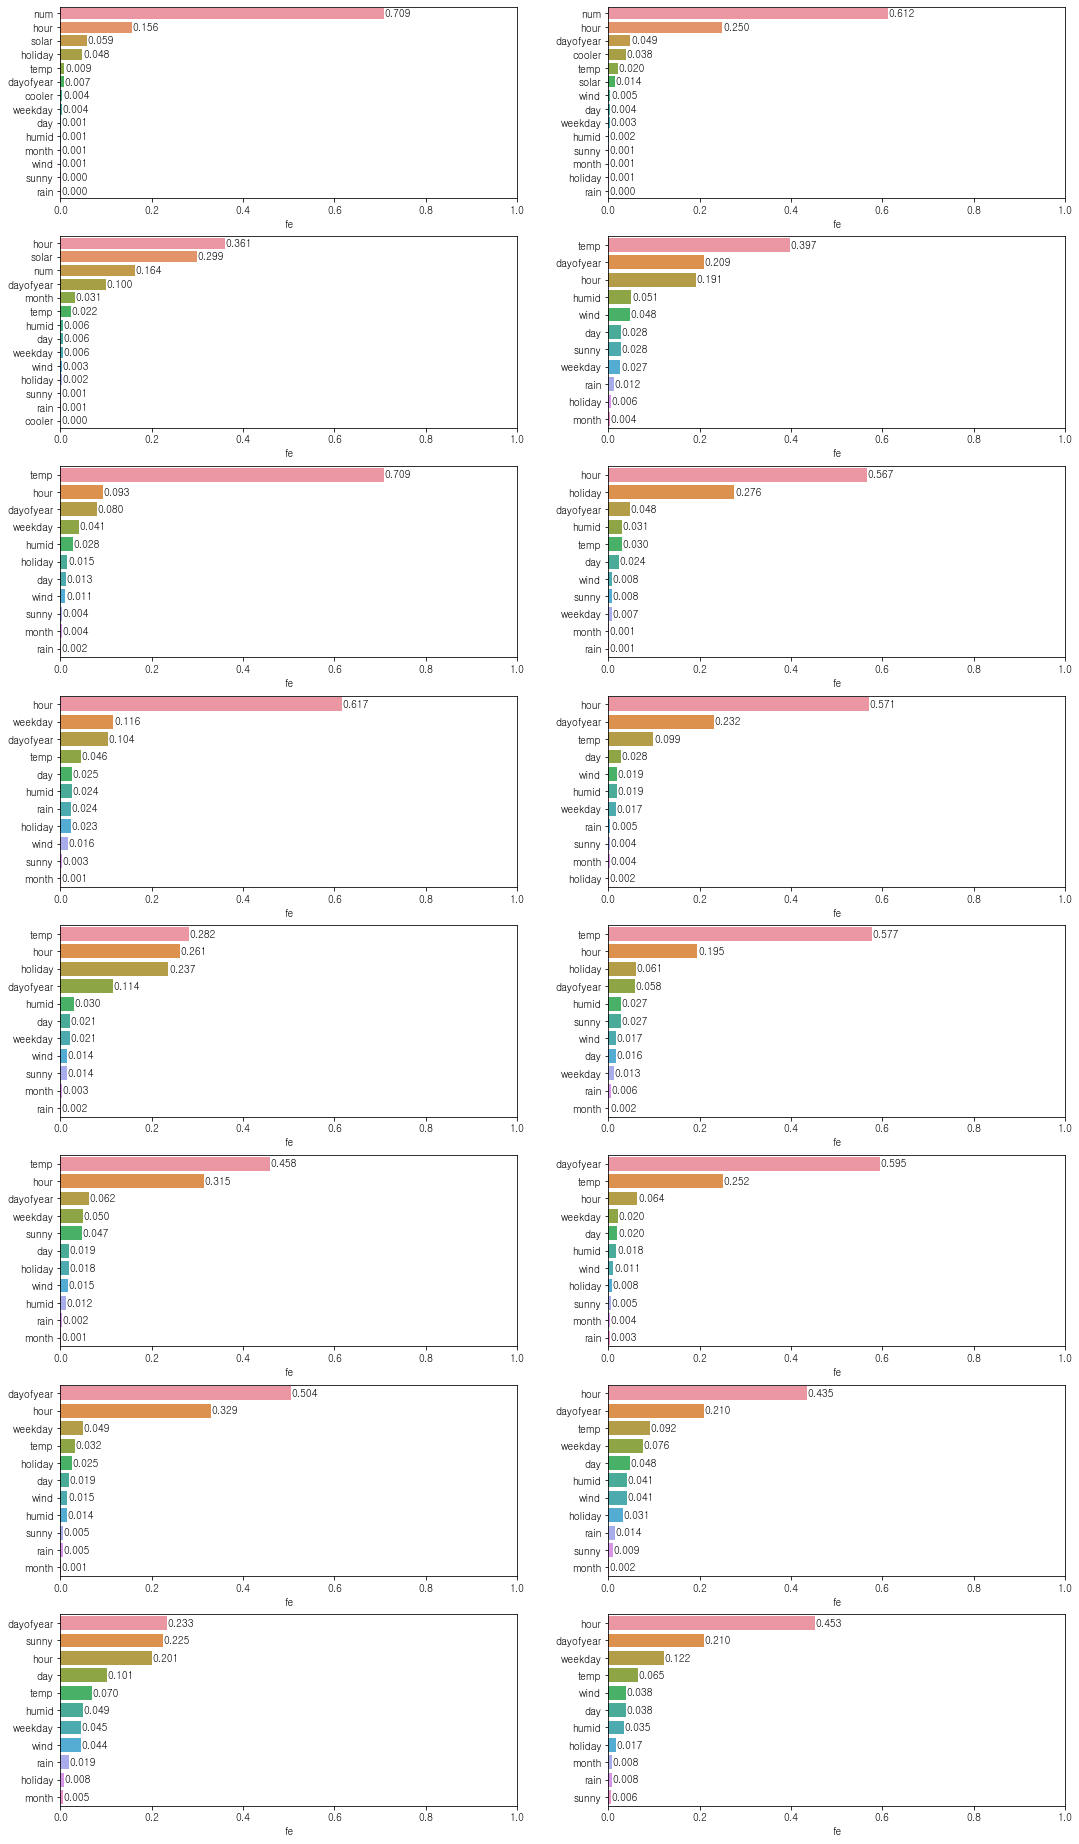

In [360]:
fig = plt.figure(figsize=(18, 50))
for i, n in enumerate(range(len(X.km_cluster.unique()))):
    plt.subplot(12, 2, i+1)
    if len(fe[i]) == 14:
        fe_avg = pd.DataFrame(fe[i], index=train_cl_0.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)
    else:
        fe_avg = pd.DataFrame(fe[i], index=train_cl_5.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)
        
    plt.xlim(right=1)
    plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

    # Annotate every single Bar with its value, based on it's width           
    for bar in plots.patches:
        width = bar.get_width()
        plt.text(0.03 + bar.get_width(),
                 bar.get_y() + 0.5 * bar.get_height(),
                 '{:.3f}'.format(width),
                 ha='center', va='center')

- 군집별, 건물별 모델링 결과 변수 중요도가 상이하게 나오는 것을 알 수 있습니다.
- temp, hour, dayofyear 등등 가장 중요한 변수가 다르게 나타납니다.

# 4. 최종 정리

## 4.1 그렇다면 전력사용량을 어떻게 줄일 수 있을까?

### 4.1.1 군집별 패턴 분석을 통해 해당 건물의 용도를 파악하고, 용도에 따라 다른 전력사용량 요인을 파악한다.

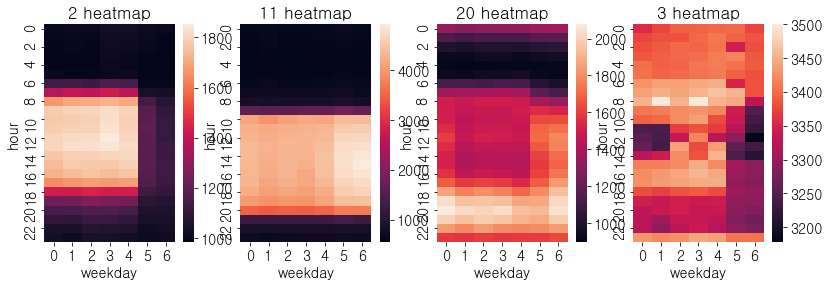

In [117]:
cluster_sample = [2, 11, 20, 3]
fig = plt.figure(figsize=(17, np.ceil(len(cluster_sample)/5)*4))
for i, n in enumerate(cluster_sample):
    plt.subplot(np.ceil(len(cluster_sample)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

- 본 분석에서는 클러스터링을 통해 4가지 유형의 군집으로 건물들을 나누었습니다.
- 그를 통해 각 유형별로 용도를 추정할 수 있었습니다.
- 활동가형은 오피스 건물, 외교관형은 상업 건물, 활동가형은 번화가 건물 등입니다.


- **각 유형에 따른 용도 추정은, 전략사용량의 주요 요인을 파악할 수 있는 힌트가 될 것입니다.**


- 오피스형 건물은 냉난방 시스템이 멈추지 않고 돌아갈 것이며, 회사의 서버나 전자기기들이 주요 요인일 수 있습니다.
- 상업형 건물들은 조명을 오래 켜고 있으며, 상업의 목적을 위한 별도의 전자기기들이 존재할 수 있습니다.
- 이러한 세부적인 원인을 파악하는 부분부터 전력 사용량을 줄일 수 있는 시발점이 될 수 있을 것입니다.

### 4.1.2 건물의 유형별로 전력사용량이 집중되는 시간을 파악하고, 해당 시간대의 사용량을 줄이는 방법을 모색한다.

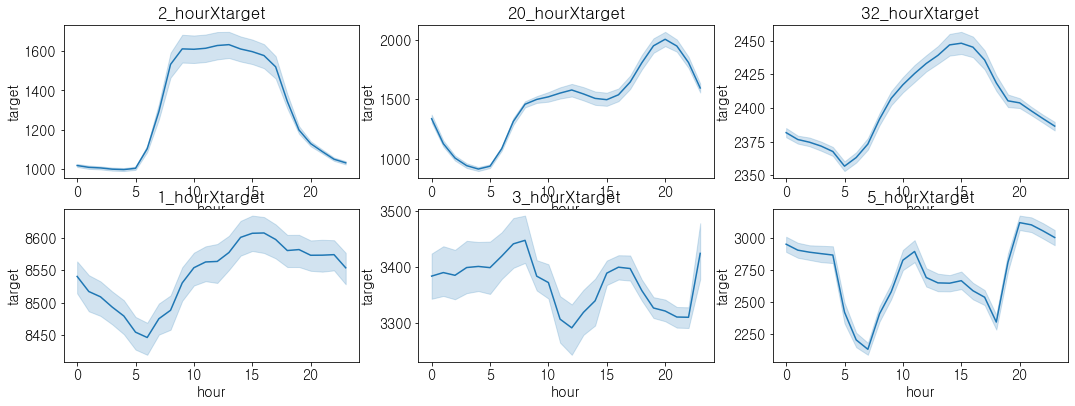

In [124]:
sample = [2, 20, 32, 1, 3, 5]
fig = plt.figure(figsize=(18, 40))
for i, n in enumerate(sample):
    plt.subplot(12, 3, i+1)
    plt.title("{}_hourXtarget".format(n))
    sns.lineplot(data=train.loc[train.num == n], x='hour', y='target')

- 오피스 건물로 추정되는 전략가형은 낮에 전력사용이 집중됩니다.
- Cooler 설치 비율이 유독 높은 이유도 이 때문일 것입니다.
- 반면에 번화가형 건물로 추정되는 활동가형은 밤에 전력사용이 집중됩니다.


- **이처럼 전력사용량이 집중되는 시간을 통해, 해당 시간대의 전력사용량을 절감할 수 있는 방법을 모색할 수 있습니다.**


- 본 대회에서 제공된 Cooler와 Solar 시스템은 이러한 결과에 적합한 시스템일 것입니다.

### 4.1.3 기상의 영향을 많이 받는 유형의 건물들은 기상 예보를 통해 전력사용량 증가에 선제적 대응을 한다.

In [125]:
temp_sample = [32, 31, 30, 60, 28, 44]
fig = plt.figure(figsize=(18, 40))
for i, n in enumerate(temp_sample):
    plt.subplot(12, 6, i+1)
    plt.title("{}_tempXtarget".format(n))
    sns.regplot(data=train.loc[train.num == n], x='temp', y='target')

- 외교관형의 건물들은 기상 요인에 매우 높은 영향을 받는 것을 알 수 있었습니다.
- 반면에 연예인형은 기상의 영향을 거의 받지 않았습니다.


- **기상 예보를 통해 전력사용량을 예측하고, 예상되는 전략사용량에 대해 선제적 대응을 할 수 있습니다.**


- 예를 들어 기상 요인의 영향을 많이 받는 외교관형 건물들에게, 예측되는 전력사용량보다 낮게 사용한다면 혜택이나 인증을 제공할 수도 있습니다.
- 또한 외교관형의 건물들을 집단으로 관리하는 시스템을 모색할 수도 있을 것입니다.

### 4.1.4 각 군집별, 건물별 모델링을 통해 전력사용량에 영향을 미치는 주요 변수들을 파악하고 대응 가능한 건물을 선별 및 관리한다.

In [373]:
sample = {0: '전략가형', 2:'활동가형', 4:'31번건물', 14:'9번건물'}
fig = plt.figure(figsize=(18, 50))
for i, d in enumerate(sample.items()):
    plt.subplot(12, 2, i+1)
    if len(fe[d[0]]) == 14:
        fe_avg = pd.DataFrame(fe[d[0]], index=train_cl_0.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)
    else:
        fe_avg = pd.DataFrame(fe[d[0]], index=train_cl_5.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)
        
    plt.title('{} 변수 중요도'.format(d[1]))
    plt.xlim(right=1)
    plt.xticks([])
    plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

- 모델링을 통해 군집별, 건물별로 어떤 변수가 전력사용량 예측에 큰 영향을 미치는지 파악할 수 있습니다.
- 전략가형 건물들과는 다르게 활동가형 건물은 hour와 solar가 높은 영향을 끼치고 있습니다.
- 31번 건물 같은 경우는 기온이 가장 중요한 변수이며, 9번 건물은 모든 변수의 중요도가 낮게 형성되고 있습니다.


- **이를 통해 전력 사용량에 영향을 미치는 주요 요인에 따라 전력 사용량 관리가 가능한 군집과 건물을 선별하고, 집중관리할 수 있습니다.**


- 예를 들어 Solar의 중요도가 높은 활동가형 변수 같은 경우, 태양광발전시스템 설치를 통해 전력 사용량 절감을 노려볼 수 있습니다.
- 31번 건물과 비슷한 유형의 건물은 기온의 변화에 따른 전력 사용량을 절감할 수 있는 방안을 적용할 수 있습니다.

## 4.2 한계점

**비전기냉방시스템과 태양광발전시스템의 영향을 조사할 수 있는 추가 변수가 필요하다.**

In [122]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.title("cooler_on")
sns.regplot(data=peak_df_0_1, x='temp', y='target')
plt.ylim(top=4, bottom=-3)

plt.subplot(2, 2, 2)
plt.title("cooler_off")
sns.regplot(data=peak_df_0_0, x='temp', y='target')
plt.ylim(top=4, bottom=-3)

plt.subplot(2, 2, 3)
plt.title("solar_on")
sns.regplot(data=peak_df_1_1, x='sunny', y='target')
plt.ylim(top=40, bottom=-40)

plt.subplot(2, 2, 4)
plt.title("solar_off")
sns.regplot(data=peak_df_1_0, x='sunny', y='target')
plt.ylim(top=40, bottom=-40)

plt.show()

- cooler와 solar 시스템 변수는 건물별로 살펴보았을 때도, 설치유무를 기준으로 살펴보았을 때도, 이렇다할 상관성은 보이지 않았습니다.
- 그러나 두 변수는 랜덤포레스트 군집별 모델링에서 꽤나 높은 중요도를 보였습니다.
- 두 변수가 각 유형별 건물들의 전력사용량에 영향을 미치고 있다는 것은 당연하겠지만, 선형적으로 파악하기에는 한계가 있어 보입니다.
- 두 변수의 영향을 더 자세히 알아볼 수 있는 방법론이나 데이터가 필요할 것 같습니다.

끝으로, 모델을 통해 각 건물의 전력 소모량에 대해 보다 정확한 예측이 가능하다면,<br>
전력 소모를 줄이기 위해 다방면으로 활용할 수 있을 것입니다.<br>

부족한 분석을 봐주셔서 정말 감사합니다. :)

이상, **끙정**이었습니다.

In [129]:
Image(url=cl_url, width=800)